In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import altair as alt
import re
import os
import matplotlib.pyplot as plt
from langdetect import detect, DetectorFactory
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.impute import SimpleImputer
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
from sklearn.preprocessing import normalize
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA as SklearnPCA

import dtale
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

try:
    from scipy import sparse
except Exception:
    sparse = None

import project_fuctions as functions
DetectorFactory.seed = 42

alt.data_transformers.disable_max_rows()


DataTransformerRegistry.enable('default')

## Reading data

In [2]:
artists_path = 'data\\artists.csv'
tracks_path = 'data\\tracks.csv'

This code automatically detects the correct separator for two dataset files (tracks and artists) by checking which character — comma, semicolon, or tab — appears most in the first line. It then loads each file into a pandas DataFrame using the detected separator, prints their shapes, and displays the first few rows.

 The tracks dataset has 11,166 rows and 45 columns, while the artists dataset has 104 rows and 14 columns.

In [3]:
# Funzione helper per capire il separatore corretto
def detect_separator(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        sample = f.readline()
    # Conta quanti separatori compaiono
    seps = {',': sample.count(','), ';': sample.count(';'), '\t': sample.count('\t')}
    best_sep = max(seps, key=seps.get)
    print(f"Detected separator for {filepath}: '{best_sep}'")
    return best_sep

# Rileva automaticamente il separatore
sep_tracks = detect_separator(tracks_path)
sep_artists = detect_separator(artists_path)

print('------------------------------------')

# Carica i dataset in base al separatore rilevato
tracks = pd.read_csv(tracks_path, sep=sep_tracks, encoding='utf-8', engine='python')
artists = pd.read_csv(artists_path, sep=sep_artists, encoding='utf-8', engine='python')

df = tracks.merge(
    artists,
    left_on="id_artist",
    right_on="id_author",
    how="left",
    suffixes=("", "_artist")
)

# Mostra alcune info per verifica
print(f"Tracks shape: {tracks.shape}")
print(f"Artists shape: {artists.shape}")
print("Shape df (merged):", df.shape)
print('------------------------------------')

print('TRACKS')
display(tracks.head(3))

print('------------------------------------')
print('ARTISTS')
display(artists.head(3))

print('------------------------------------')
print('MERGERD')
display(df.head(3))

Detected separator for data\tracks.csv: ','
Detected separator for data\artists.csv: ';'
------------------------------------
Tracks shape: (11166, 45)
Artists shape: (104, 14)
Shape df (merged): (11166, 59)
------------------------------------
TRACKS


,id,id_artist,name_artist,full_title,title,featured_artists,primary_artist,language,album,stats_pageviews,...,album_type,disc_number,track_number,duration_ms,explicit,popularity,album_image,id_album,lyrics,modified_popularity
0,TR934808,ART04205421,Rosa Chemical,​polka 2 :-/ by Rosa Chemical (Ft. Ernia & Guè),​polka 2 :-/,"Ernia, Guè",Rosa Chemical,pl,FOREVER AND EVER,196033.0,...,album,1.0,3.0,207761.0,True,46.0,https://i.scdn.co/image/ab67616d0000b2736d5e14...,ALB115557,"Oplà, ah\nBdope, chiama due b—\n\nMi candidere...",False
1,TR760029,ART04205421,Rosa Chemical,POLKA by Rosa Chemical (Ft. Thelonious B.),POLKA,Thelonious B.,Rosa Chemical,en,FOREVER AND EVER,164450.0,...,album,1.0,3.0,207761.0,True,46.0,https://i.scdn.co/image/ab67616d0000b2736d5e14...,ALB115557,"Greg Willen, non dormire\n(Brr-poh)\n\nT-T-Tro...",False
2,TR916821,ART04205421,Rosa Chemical,​britney ;-) by Rosa Chemical (Ft. MamboLosco ...,​britney ;-),"MamboLosco, RADICAL",Rosa Chemical,en,FOREVER AND EVER,58313.0,...,album,1.0,1.0,193544.0,True,39.0,https://i.scdn.co/image/ab67616d0000b2736d5e14...,ALB115557,"Mothz\nYeah, yeah, yeah-yeah\nBdope, chiama du...",False


------------------------------------
ARTISTS


,id_author,name,gender,birth_date,birth_place,nationality,description,active_start,active_end,province,region,country,latitude,longitude
0,ART82291002,99 posse,M,NaN,NaN,NaN,gruppo musicale italiano,1991-01-01,NaN,NaN,NaN,NaN,NaN,NaN
1,ART53496045,achille lauro,M,1990-07-11,Verona,Italia,cantautore e rapper italiano (1990-),2012-01-01,NaN,Verona,Veneto,Italia,45.442498,10.985738
2,ART18853907,alfa,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


------------------------------------
MERGERD


,id,id_artist,name_artist,full_title,title,featured_artists,primary_artist,language,album,stats_pageviews,...,birth_place,nationality,description,active_start,active_end,province,region,country,latitude,longitude
0,TR934808,ART04205421,Rosa Chemical,​polka 2 :-/ by Rosa Chemical (Ft. Ernia & Guè),​polka 2 :-/,"Ernia, Guè",Rosa Chemical,pl,FOREVER AND EVER,196033.0,...,Grugliasco,Italia,rapper e cantautore italiano (1998-),2015-01-01,NaN,Torino,Piemonte,Italia,45.068046,7.57762
1,TR760029,ART04205421,Rosa Chemical,POLKA by Rosa Chemical (Ft. Thelonious B.),POLKA,Thelonious B.,Rosa Chemical,en,FOREVER AND EVER,164450.0,...,Grugliasco,Italia,rapper e cantautore italiano (1998-),2015-01-01,NaN,Torino,Piemonte,Italia,45.068046,7.57762
2,TR916821,ART04205421,Rosa Chemical,​britney ;-) by Rosa Chemical (Ft. MamboLosco ...,​britney ;-),"MamboLosco, RADICAL",Rosa Chemical,en,FOREVER AND EVER,58313.0,...,Grugliasco,Italia,rapper e cantautore italiano (1998-),2015-01-01,NaN,Torino,Piemonte,Italia,45.068046,7.57762


## DATA CLEANING

### Fixing duplicates

#### Fixing Duplicated Tracks Id
After reviewing the songs associated with the duplicated IDs, we found that each duplicated ID corresponds to different songs, except for one case that will be treated later. Therefore, the most reasonable solution is to modify the duplicated IDs by appending the row number to each one. This approach ensures that all songs are preserved while maintaining unique identifiers for every track.

In [4]:
# Identify duplicated IDs
duplicate_mask = tracks.duplicated(subset='id', keep=False)

# Assign new unique IDs only to duplicated rows
tracks.loc[duplicate_mask, 'id'] = (
    tracks.loc[duplicate_mask]
    .apply(lambda x: f"{x['id']}_{x.name}", axis=1)
)


print("Example of updated duplicates:")
display(tracks[duplicate_mask][['id', 'full_title']])


Example of updated duplicates:


,id,full_title
43,TR715264_43,​non è normale by Rosa Chemical
120,TR976686_120,Ibridi by Beba
141,TR230274_141,SaN LoREnZo by Alfa (Ft. Annalisa)
159,TR531651_159,Serenata - From “Forever Out of My League” by ...
199,TR898853_199,​oh 9od by thasup (Ft. nayt)
...,...,...
10879,TR292480_10879,Nel mio piccolo by Fedez
10915,TR978886_10915,L'arte di accontentare by Fedez
10962,TR925275_10962,Bimbo Speciale by Fedez
11007,TR747430_11007,Scooteroni by Marracash & Guè


#### Fixing Duplicated Tracks full_title

The duplicated titles  — "BUGIE by Madame (Ft. Carl Brave & Rkomi)" and "sentimi by Madame" — actually refer to the same songs released in two different formats: one from the album and one from the single version.
We decided to keep the duplicated tracks in the dataset but add a clear indication in the full_title to show whether each song comes from a single or an album. This way, all versions are preserved while making it easy to distinguish between different releases of the same song

In [5]:
# Find duplicated full_titles
duplicate_mask = tracks.duplicated(subset='full_title', keep=False)

# Update only the duplicated titles by appending album_type
tracks.loc[duplicate_mask, 'full_title'] = (
        tracks.loc[duplicate_mask, 'full_title'] +
        " (" + tracks.loc[duplicate_mask, 'album_type'].fillna('unknown').str.capitalize() + ")"
)

# Verify the changes
duplicate_titles = tracks[tracks.duplicated(subset='full_title', keep=False)].sort_values('full_title')
display(duplicate_titles[['full_title', 'album_type', 'id']])


,full_title,album_type,id


#### Fixing duplicate coloums

In this section, we remove all columns that store the same information or redundant representations of it.

##### Name of the artists

In [6]:
df.drop(columns=['name_artist'], inplace=True)

##### Album
Once we understand that album_name is more stable than album, we can remove both coloums (album and id_album). We remove also album_image because it is useless.

In [7]:
df.drop(columns=['album'], inplace=True)
df.drop(columns=['id_album'], inplace=True)
df.drop(columns=['album_image'], inplace=True)

##### Title
We are going to take only full_title,

In [8]:
df.drop(columns=['title'], inplace=True)

#### Fixing duplicate tracks based on lyrics
As previously identified, there are 9 duplicate rows based on identical lyrics. To maintain data integrity, we will remove these duplicates from the dataset. This step is crucial to prevent skewing any analysis or derived features that rely on the lyrics content.

In [9]:
original_row_count = len(df)
print(f"Original DataFrame shape: {df.shape}")

non_nan_mask = df['lyrics'].notna()
df_nan_lyrics = df[~non_nan_mask]
df_non_nan_lyrics = df[non_nan_mask]

print(f"  > Found {len(df_nan_lyrics)} rows with NaN lyrics (keeping all for now).")
print(f"  > Found {len(df_non_nan_lyrics)} rows with non-NaN lyrics (checking for duplicates).")

duplicate_mask = df_non_nan_lyrics.duplicated(subset=['lyrics', 'album_type'], keep='first')

indices_to_drop = df_non_nan_lyrics[duplicate_mask].index

print(f"  > Found {len(indices_to_drop)} true logical duplicates (same lyrics AND album_type) to remove.")

df.drop(indices_to_drop, inplace=True)

cleaned_row_count = len(df)
rows_removed_total = original_row_count - cleaned_row_count

print(f"\nDataFrame shape after dropping logical duplicates: {df.shape}")
print(f"Total rows removed: {rows_removed_total}")

# We now expect a smaller number (e.g., 8 instead of 10) because
# the 'Madame' tracks (and any others with different album_type) were kept.
print(f"SUCCESS: Removed {rows_removed_total} rows. Duplicates with different 'album_type' were kept.")



Original DataFrame shape: (11166, 55)
  > Found 3 rows with NaN lyrics (keeping all for now).
  > Found 11163 rows with non-NaN lyrics (checking for duplicates).
  > Found 8 true logical duplicates (same lyrics AND album_type) to remove.

DataFrame shape after dropping logical duplicates: (11158, 55)
Total rows removed: 8
SUCCESS: Removed 8 rows. Duplicates with different 'album_type' were kept.


### Filling Missing Value

#### Active End

It is a complete empy coloum so we can delete it.

In [10]:
df.drop(columns=['active_end'], inplace=True)

#### Popularity


In [11]:
display(
    df.loc[
        (df['popularity'].isna()),
        ['popularity', 'full_title']
    ].head(50)
)
print(f"We have {df['popularity'].isna().sum()} null value in popularity")

,popularity,full_title
3716,NaN,Voci di Piazza by Frankie hi-nrg mc
3737,NaN,Mattatoy by Frankie hi-nrg mc (Ft. Gianluca Ni...


We have 2 null value in popularity


Given that the popularity score is a continuous metric with skewed distribution and that dropping rows would remove valuable tracks, we opted for median-based imputation.

In [12]:
df['popularity'] = pd.to_numeric(df['popularity'], errors='coerce')

df['popularity_missing_flag'] = df['popularity'].isna().astype(int)
median_pop = df['popularity'].median()
df['popularity'] = df['popularity'].fillna(median_pop)


#### Filling Birth Dates
This code manually fills missing birth dates for specific artists in the dataset. It first defines a dictionary mapping artist names to their known or estimated birth dates.

9 entries couldn’t be filled so their birth dates are intentionally left blank in the dictionary. For Miss Keta, the birth date is unknown, so no accurate value can be provided. The others — Bushwaka, Sottotono, Dark Polo Gang, Cor Veleno, Colle Der Fomento, Club Dogo, Articolo 31, and 99 Posse — are all music groups or duos, not individual artists, meaning they don’t have a single birth date associated with them.

In [13]:
# --- 1. Define the Missing Dates as a Dictionary ---
# Source of truth for the manual fill
birth_dates_to_fill = {
    'alfa': '2000-08-22',
    'anna pepe': '2003-08-15',
    'beba': '1994-10-10',
    'bigmama': '2000-03-10',
    'brusco': '1974-01-04',
    'caneda': '1976-09-30',
    'dargen d_amico': '1980-11-29',
    'guè pequeno': '1980-12-25',
    'johnny marsiglia': '1986-08-05',
    'nerone': '1991-05-23',
    'priestess': '1996-08-20',
    'samuel heron': '1991-01-01',
    'shiva': '1999-08-27',
    'yeиdry': '1993-07-27',
    'o zulù': '1970-11-15',
    'skioffi':'1992-06-05',
    'eva rea':'1993-01-01',
    'hindaco':'1996-01-01',
    'joey funboy':'1995-01-01',
    'mistico':'1982-01-01',
    'mike24':'1985-08-02',
    'doll kill':'1996-01-01',
    'miss simpatia':'1986-03-23',
    'miss keta':'',#unknown
    'bushwaka':'',#duo
    'sottotono':'',#group
    'dark polo gang':'',#group
    'cor veleno':'',#group
    'colle der fomento':'',#group
    'club dogo':'',#group
    'articolo 31':'',#group
    '99 posse':''#gruppo



    }

# --- 2. Fill the Missing Data (Imputation) ---

# Convert the dictionary to a Pandas Series for easy lookup and indexing
birth_date_series = pd.Series(birth_dates_to_fill)

# Iterate through the artists in your fill list and update the DataFrame
for artist, bday in birth_date_series.items():
    # Use .loc to find rows where 'artist_name' matches and update 'birth_date'
    # The second part of the condition (artist_df['birth_date'].isna()) ensures
    # we only overwrite if the date was previously missing (NaN).
    df.loc[
        (df['name'] == artist) & (df['birth_date'].isna()),
        'birth_date'
    ] = bday

# --- 3. Final Conversion and Verification ---

# Convert the 'birth_date' column to the proper datetime format again
# (This is crucial for accurate age calculation)
df['birth_date'] = pd.to_datetime(df['birth_date'], errors='coerce')

# Optional: Print out the affected rows to verify the fix
print("--- Verification of Filled Birth Dates  ---")
# Filter the DataFrame to show only the artists we just updated
filled_artists = df[df['name'].isin(birth_dates_to_fill.keys())]

# Show the unique artist names and their newly filled birth dates
print(filled_artists[['name', 'birth_date']].drop_duplicates().to_string(index=False))

--- Verification of Filled Birth Dates  ---
             name birth_date
             beba 1994-10-10
             alfa 2000-08-22
           nerone 1991-05-23
      guè pequeno 1980-12-25
          skioffi 1992-06-05
        club dogo        NaT
          hindaco 1996-01-01
    miss simpatia 1986-03-23
          eva rea 1993-01-01
           o zulù 1970-11-15
        doll kill 1996-01-01
           yeиdry 1993-07-27
 johnny marsiglia 1986-08-05
      articolo 31        NaT
          mistico 1982-01-01
        miss keta        NaT
   dargen d_amico 1980-11-29
         bushwaka        NaT
         99 posse        NaT
          bigmama 2000-03-10
           brusco 1974-01-04
       cor veleno        NaT
           mike24 1985-08-02
   dark polo gang        NaT
colle der fomento        NaT
        sottotono        NaT
        anna pepe 2003-08-15
     samuel heron 1991-01-01
      joey funboy 1995-01-01
        priestess 1996-08-20
            shiva        NaT
           caneda 1976-09-30

##### Checking distribution after filling Bithdate


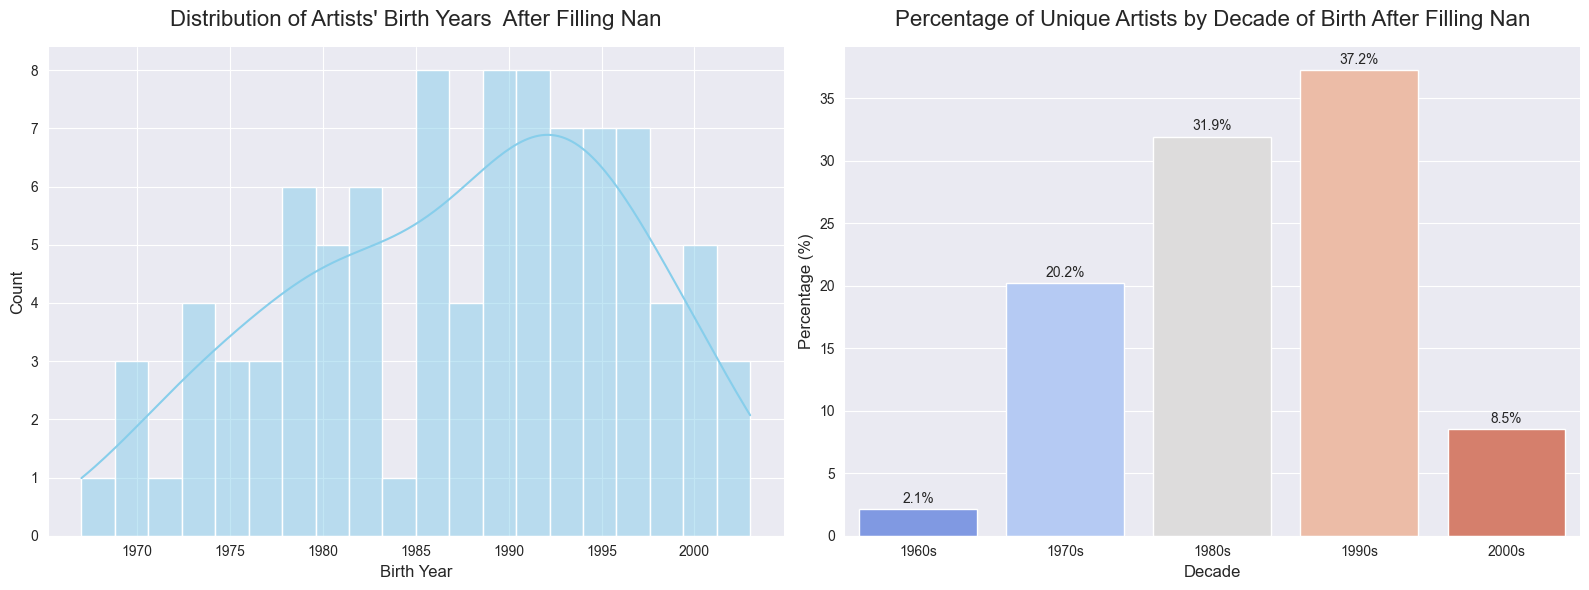

Number of unique artists per age:
birth_date
22    1
23    2
24    2
25    3
26    1
27    3
28    3
29    4
30    2
31    5
32    7
33    3
34    5
35    2
36    6
37    2
38    2
39    4
40    4
41    1
42    2
43    4
44    1
45    4
46    6
49    3
50    3
51    1
52    3
53    1
55    2
56    1
58    1
Name: count, dtype: int64


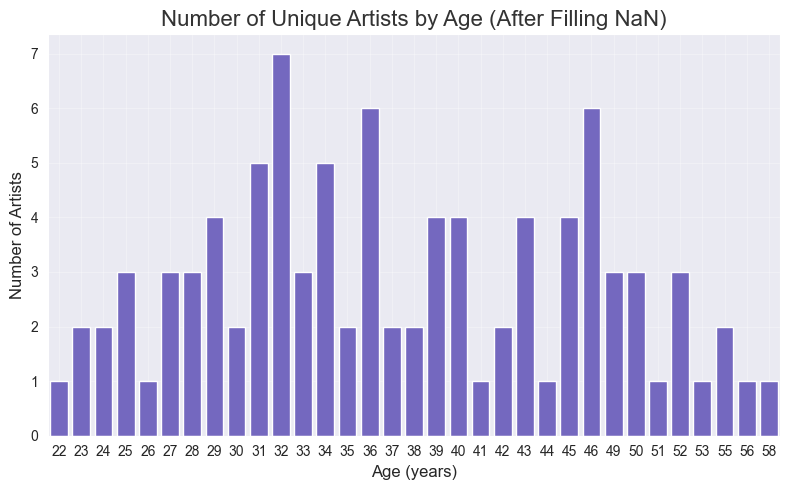

In [14]:
functions.plot_birth_decades(df, "Distribution of Artists' Birth Years  After Filling Nan",'Percentage of Unique Artists by Decade of Birth After Filling Nan')
functions.plot_artist_ages(df,'Number of Unique Artists by Age (After Filling NaN)')

#### Filling Active Start Date

Active start dates have been filled in the 'active_start' column.
Percentage of Unique Artists by Active Start Decade After Filling Missing Values
  decade  percent
0  1980s      4.0
1  1990s     32.0
2  2000s     32.0
3  2010s     32.0


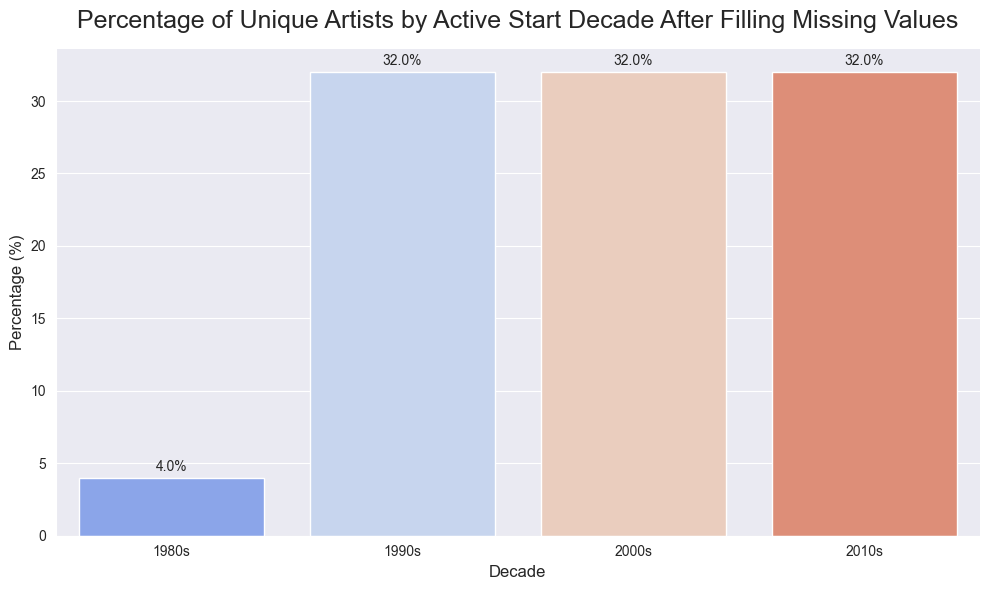

Age of unique Artists When They Started Their Career After Filling Missing Values
1     1
7     1
10    1
13    1
14    3
15    4
16    1
17    8
18    8
19    3
20    5
21    4
22    3
23    1
24    1
27    1
Name: count, dtype: int64


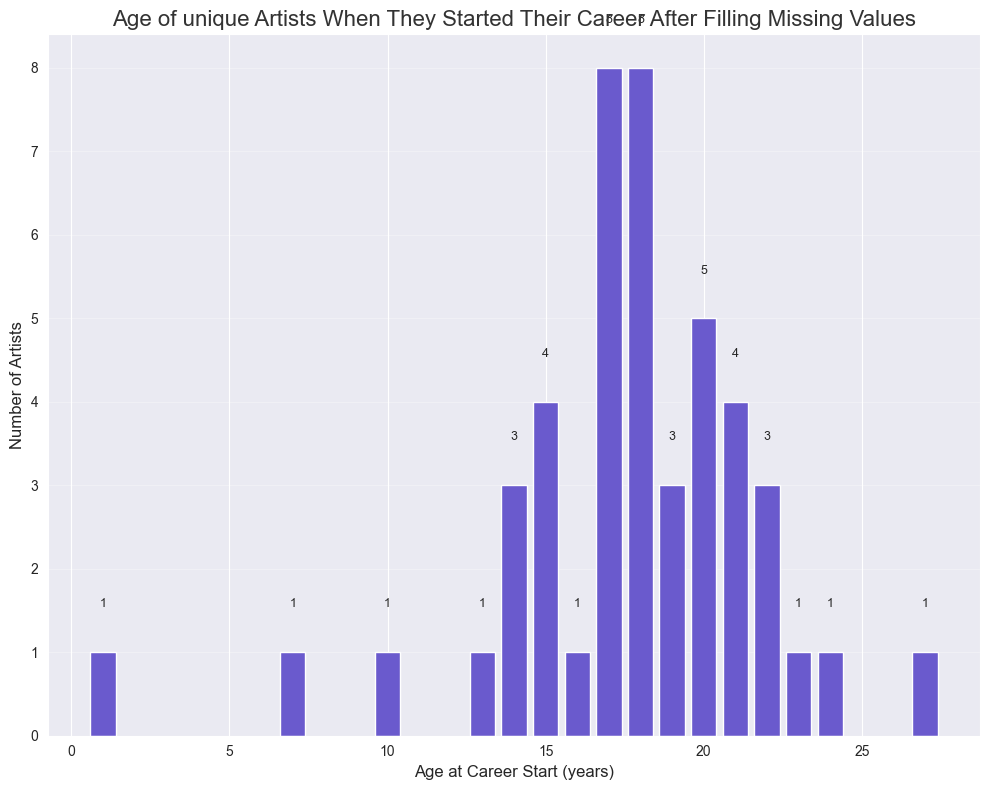

In [15]:
# Total number of unique artists missing 'active_start': 54
active_starts_consolidated = {
    'alfa': '01-15-2017',
    'anna pepe': '01-01-2018',
    'babaman': '01-01-1989',
    'beba': '11-01-2015',
    'brusco': '01-01-1991',
    'capo plaza': '01-01-2013',
    'chadia rodriguez': '01-01-2017',
    'clementino': '04-29-2006',
    'dargen d_amico': '01-01-1999',
    'don joe': '01-01-1999',
    'fred de palma': '01-01-2008',
    'geolier': '01-01-2018',
    'guè pequeno': '01-01-1997',
    'miss keta': '01-01-2013',
    'shiva': '01-01-2014',
    'tedua': '01-01-2013',
    'tony effe': '01-01-2014',
    'sottotono': '01-01-1994',
    'bushwaka': '01-01-2007',
    'mike24': '01-01-2009',
    'mistico': '01-01-2008',
    'skioffi': '01-01-2014',
    "caneda": "01-01-1993",
    "club dogo": "01-01-2002",
    "colle der fomento": "01-01-1994",
    "dani faiv": "01-01-2014",
    "doll kill": "01-01-2012",
    "drefgold": "01-01-2012",
    "entics": "01-01-2004",
    "eva rea": "12-18-2014",
    "hell raton": "01-01-2010",
    "hindaco": "02-21-2020",
    "jack the smoker": "01-01-2000",
    "joey funboy": "01-01-2016",
    "johnny marsiglia": "01-01-2007",
    "la pina": "01-01-1994",
    "luchè": "01-01-1997",
    "mambolosco": "02-10-2017",
    "massimo pericolo": "01-01-2016",
    "miss simpatia": "01-01-2007",
    "mistaman": "01-01-1994",
    "mondo marcio": "01-01-2003",
    "nerone": "01-01-2008",
    "niky savage": "01-01-2021",
    "o zulù": "01-01-1991",
    "papa v": "01-01-2020",
    "rondodasosa": "01-01-2020",
    "samuel heron": "01-01-2012",
    "shablo": "01-01-1999",
    "slait": "01-01-2010",
    "tony boy": "01-01-2018",
    "tormento": "01-01-1991",
    "yeиdry": "01-01-2012",
    "yung snapp": "01-01-2012",
}


# Convert the dictionary to a Pandas Series for efficient filling
start_date_series = pd.Series(active_starts_consolidated)

# Iterate and fill the missing data in the 'active_start' column
for artist, start_date in start_date_series.items():
    # Use .loc to find rows where 'artist_name' matches and update 'active_start'
    df.loc[
        df['name'] == artist,
        'active_start'
    ] = start_date

# Ensure the 'active_start' column is a proper datetime object
df['active_start'] = pd.to_datetime(df['active_start'], errors='coerce')

print("Active start dates have been filled in the 'active_start' column.")

functions.plot_active_start_decades(df,'Percentage of Unique Artists by Active Start Decade After Filling Missing Values')
functions.plot_age_at_career_start(df,'Age of unique Artists When They Started Their Career After Filling Missing Values')

#### Filling missing albums for tracks
We have 78 tracks without albums. We managed to find the albums for 16 tracks.

In [16]:
# --- 1. Define mapping for known tracks ---
# Keys = track title (partial or exact match)
# Values = album name, release date, and type
album_updates = {

    "PTS (PoiTiSpiego/PostTraumaticStress)": {
        "album_name": "Gilmar / Embrionale",
        "album_release_date": "2012-01-01",
        "album_type": "album"
    },
    "Quelli che benpensano": {
        "album_name": "La morte dei miracoli",
        "album_release_date": "1997-01-01",
        "album_type": "album"
    },
    "Autodafè": {
        "album_name": "La morte dei miracoli",
        "album_release_date": "1997-01-01",
        "album_type": "album"
    },
    "Fight da faida": {
        "album_name": "La morte dei miracoli",
        "album_release_date": "1997-01-01",
        "album_type": "album"
    },
    "Giù le mani da Caino": {
        "album_name": "La morte dei miracoli",
        "album_release_date": "1997-01-01",
        "album_type": "album"
    },
    "Pedala": {
        "album_name": "La morte dei miracoli",
        "album_release_date": "1997-01-01",
        "album_type": "album"
    },
    "Accendimi": {
        "album_name": "La morte dei miracoli",
        "album_release_date": "1997-01-01",
        "album_type": "album"
    },
    "Fili": {
        "album_name": "La morte dei miracoli",
        "album_release_date": "1997-01-01",
        "album_type": "album"
    },
    "Rap Lamento": {
        "album_name": "La morte dei miracoli",
        "album_release_date": "1997-01-01",
        "album_type": "album"
    },
    "Cali di tensione": {
        "album_name": "La morte dei miracoli",
        "album_release_date": "1997-01-01",
        "album_type": "album"
    },
    "Cubetti tricolori": {
        "album_name": "La morte dei miracoli",
        "album_release_date": "1997-01-01",
        "album_type": "album"
    },
    "Faccio la mia cosa": {
        "album_name": "La morte dei miracoli",
        "album_release_date": "1997-01-01",
        "album_type": "album"
    },
    "Libri Di Sangue": {
        "album_name": "La morte dei miracoli",
        "album_release_date": "1997-01-01",
        "album_type": "album"
    },
    "Potere Alla Parola": {
        "album_name": "La morte dei miracoli",
        "album_release_date": "1997-01-01",
        "album_type": "album"
    },
    "Nuvole": {
        "album_name": "La morte dei miracoli",
        "album_release_date": "1997-01-01",
        "album_type": "album"
    },
    "Il beat come anestetico": {
        "album_name": "La morte dei miracoli",
        "album_release_date": "1997-01-01",
        "album_type": "album"
    },
}

# --- 2. Define a helper function to safely update missing info ---
def update_album_info(row):
    for track, info in album_updates.items():
        if track.lower() in str(row['full_title']).lower():  # partial match, case-insensitive
            if pd.isna(row['album_name']):
                row['album_name'] = info['album_name']
            if pd.isna(row['album_release_date']):
                row['album_release_date'] = pd.to_datetime(info['album_release_date'])
            if pd.isna(row['album_type']):
                row['album_type'] = info['album_type']
            break
    return row

# --- 3. Apply to the dataset ---
df = df.apply(update_album_info, axis=1)

# --- 4. Verify the updates ---
updated = df[df['full_title'].str.contains('|'.join(album_updates.keys()), case=False, na=False)]
print(f" Updated {len(updated)} tracks with album information.")
display(updated[['full_title', 'album_name', 'album_release_date', 'album_type']])

 Updated 36 tracks with album information.


C:\Users\Michela\AppData\Local\Temp\ipykernel_16860\2030002589.py:105: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



,full_title,album_name,album_release_date,album_type
104,Fili Del Tram by Beba,Crisalide,2021-10-21,album
127,"TesTa TrA Le NuVoLE, pT. 2 by Alfa",NoRd,2021-05-14,album
131,"Testa tra le nuvole, Pt. 1 by Alfa",Before Wanderlust,2019-12-13,album
143,"Testa tra le nuvole, Pt. 0 by Alfa",Before Wanderlust,2019-12-13,album
1839,Sangue E Filigrana by Club Dogo (Ft. Vincenzo ...,MI Fist (2004 Remaster),2003-01-03,album
2773,Sulle Nuvole by Doll Kill,Sulle Nuvole (prod. Low Kidd & Young Miles),2020-01-16,single
3369,La mia ragazza mena by Articolo 31 (Ft. Bruno ...,Italiano medio,2003-11-04,album
3601,Sopra le nuvole by Neffa,Molto calmo,2013-12-11,album
3667,Quelli che benpensano by Frankie hi-nrg mc (Ft...,La morte dei miracoli,1997-01-01 00:00:00,album
3668,Autodafè by Frankie hi-nrg mc,La morte dei miracoli,1997-01-01 00:00:00,album


#### Lyrics

In [17]:
print(f"Shape before fixing NaNs: {df.shape}")
original_row_count = len(df)

# Action 1: Drop all rows where 'lyrics' is missing (in-place)
df.dropna(subset=['lyrics'], inplace=True)

rows_removed_lyrics = original_row_count - len(df)
print(f"\nShape after dropping 'lyrics' NaNs: {df.shape}")
print(f"Rows removed: {rows_removed_lyrics}")

if rows_removed_lyrics == 3:
    print("SUCCESS: Correctly removed the 3 'NaN' lyric rows.")
else:
    print(f"WARNING: Expected to remove 3 'NaN' rows, but removed {rows_removed_lyrics}.")

Shape before fixing NaNs: (11158, 55)

Shape after dropping 'lyrics' NaNs: (11155, 55)
Rows removed: 3
SUCCESS: Correctly removed the 3 'NaN' lyric rows.


### Fixing out of range and errors

####  Correcting "Priestess" Entry

Based on the inspection of the artists description above, we noticed an entry labeled “gruppo musicale canadese” (Canadian music group). Upon checking, this description is incorrectly assigned to the Italian rapper Priestess. Further research revealed a mix-up with a Canadian band that shares the same name. This confusion becomes evident when comparing the active_start year in the dataset, which matches that of the Canadian group rather than the Italian artist.

We are going to correct its data

In [18]:
print('Before')
display( df[df['description'].str.contains('gruppo musicale canadese', case=False, na=False)]
         .drop_duplicates(subset=['name'])
         .sort_values(by='name'))

print('After')
# Fix Priestess' incorrect description and active_start date
df.loc[df['name'].str.lower() == 'priestess', ['description','active_start' ]] = [
    'cantante e rapper italiana',
    '2017-01-01'

]

# Verify the update
print(df[df['name'].str.lower() == 'priestess'][['name', 'description', 'active_start']])


Before


,id,id_artist,full_title,featured_artists,primary_artist,language,stats_pageviews,swear_IT,swear_EN,swear_IT_words,...,birth_place,nationality,description,active_start,province,region,country,latitude,longitude,popularity_missing_flag
9797,TR874555,ART87389753,Maria Antonietta by Priestess,NaN,Priestess,it,36046.0,1,0,['merda'],...,NaN,NaN,gruppo musicale canadese,2003-01-01,NaN,NaN,NaN,NaN,NaN,0


After
           name                 description active_start
9797  priestess  cantante e rapper italiana   2017-01-01
9798  priestess  cantante e rapper italiana   2017-01-01
9799  priestess  cantante e rapper italiana   2017-01-01
9800  priestess  cantante e rapper italiana   2017-01-01
9801  priestess  cantante e rapper italiana   2017-01-01
9802  priestess  cantante e rapper italiana   2017-01-01
9803  priestess  cantante e rapper italiana   2017-01-01
9804  priestess  cantante e rapper italiana   2017-01-01
9805  priestess  cantante e rapper italiana   2017-01-01
9806  priestess  cantante e rapper italiana   2017-01-01
9807  priestess  cantante e rapper italiana   2017-01-01
9808  priestess  cantante e rapper italiana   2017-01-01
9809  priestess  cantante e rapper italiana   2017-01-01
9810  priestess  cantante e rapper italiana   2017-01-01
9811  priestess  cantante e rapper italiana   2017-01-01
9812  priestess  cantante e rapper italiana   2017-01-01
9813  priestess  cantante

#### Popularity

In [19]:
# Fix out-of-range popularity values
df['popularity'] = df['popularity'].clip(lower=0, upper=100)
#
display(df.loc[df['modified_popularity'] == 1, ['popularity', 'modified_popularity', 'full_title']].head(50))

,popularity,modified_popularity,full_title
1932,32.0,True,Ciao ciao 2 by Club Dogo (Ft. Emis Killa)
2304,32.0,True,Santa Margherita 104 Freestyle by Rocco Hunt
3286,0.0,True,PTS (PoiTiSpiego/PostTraumaticStress) by Ghemon
3667,100.0,True,Quelli che benpensano by Frankie hi-nrg mc (Ft...
3668,100.0,True,Autodafè by Frankie hi-nrg mc
3669,32.0,True,Fight da faida by Frankie hi-nrg mc
3670,0.0,True,Giù le mani da Caino by Frankie hi-nrg mc
3671,100.0,True,Pedala by Frankie hi-nrg mc
3672,32.0,True,Accendimi... by Frankie hi-nrg mc
3673,32.0,True,Fili by Frankie hi-nrg mc


Now we don't need anymore modified_popularity, so we can just drop it.

In [20]:
df.drop(columns=['modified_popularity'], inplace=True)
print("OK — column 'modified_popularity' has been removed.")

OK — column 'modified_popularity' has been removed.


#### Lyrics

##### Remove Junk Lyrics

In [21]:
# maximum tokens for junk lyrics: 36
# minimum tokens for actual lyrics: 108
pattern = 'Contributors|Contributor|Lyrics|COMING SOON|instrumental'

token_threshold = 60  # Safe threshold based on your analysis

# Find the indices of rows that meet BOTH conditions
conditions_to_eliminate = (
        (df['lyrics'].str.contains(pattern, case=False, na=False)) &
        (df['n_tokens'] < token_threshold)
)

# Get the actual index labels of the rows to drop
indices_to_drop = df[conditions_to_eliminate].index
num_to_eliminate = len(indices_to_drop)

print(f"Found {num_to_eliminate} 'junk AND short' rows (< {token_threshold} tokens) to ELIMINATE.")

# 2. Set the 'lyrics' column to NaN where the conditions are true
if num_to_eliminate > 0:
    df.drop(indices_to_drop, inplace=True)

    print(f"DataFrame shape AFTER elimination: {df.shape}")
    print(f"Successfully removed {num_to_eliminate} rows.")


Found 122 'junk AND short' rows (< 60 tokens) to ELIMINATE.
DataFrame shape AFTER elimination: (11033, 54)
Successfully removed 122 rows.


##### Cleaning "Contributors" Headers

In [22]:
contributor_pattern = 'Contributors|Contributor'
contributor_matches = df[df['lyrics'].str.contains(contributor_pattern, case=False, na=False)]

print(f"\nRows containing Contributors words")
print(f"Total number: {len(contributor_matches)}")
if not contributor_matches.empty:
    display(contributor_matches[['id', 'name', 'full_title', 'lyrics', 'n_tokens']].head(23))


Rows containing Contributors words
Total number: 16


,id,name,full_title,lyrics,n_tokens
1777,TR372521,clementino,Intro (Napolimanicomio) by Clementino,5 ContributorsIntro (Napolimanicomio) LyricsIl...,135.0
1955,TR194183,la pina,Dammi Ancora by La Pina,1 ContributorDammi Ancora LyricsNon fare scene...,437.0
1968,TR415938,la pina,Cin Cin by La Pina,1 ContributorCin Cin LyricsIo non so come fai ...,283.0
1974,TR902735,la pina,Tu Non Hai Mai by La Pina,1 ContributorTu Non Hai Mai LyricsTu non hai m...,301.0
1975,TR109916,la pina,Pronte A Tutto by La Pina (Ft. Sab Sista),2 ContributorsPronte A Tutto LyricsNiente più ...,446.0
1977,TR342543,la pina,Non Dimentico Più by La Pina,1 ContributorNon Dimentico Più LyricsE adesso ...,349.0
1978,TR132327,la pina,Come Ti Senti? by La Pina,1 ContributorCome Ti Senti? LyricsCome ti sent...,317.0
3639,TR865520,neffa,0 tempo e 0 vento by Neffa,3 Contributors0 tempo e 0 vento LyricsAs cores...,108.0
3697,TR_268445,frankie hi-nrg mc,Area 51 by Frankie hi-nrg mc,4 ContributorsArea 51 LyricsThis song is an in...,NaN
3702,TR_555224,frankie hi-nrg mc,Note psichedeliche d'ambiente by Frankie hi-nr...,3 ContributorsNote psichedeliche d’ambiente Ly...,NaN


In [23]:
# Remove the found pattern from the beginning of the lyrics
print(f"DataFrame shape BEFORE cleaning: {df.shape}")

indices_to_clean = df[df['lyrics'].str.contains(contributor_pattern, case=False, na=False)].index

print(f"Number of rows to clean: {len(indices_to_clean)}")

if len(indices_to_clean) > 0:
    # Definisci la regex per l'intestazione
    header_regex = r"^\s*\d+\s+Contributor(s)?.*?\s+Lyrics\s*"

    original_lyrics = df.loc[indices_to_clean, 'lyrics']

    cleaned_lyrics_series = original_lyrics.str.replace(
        header_regex, '', regex=True, flags=re.IGNORECASE
    ).str.strip()

    empty_mask = (cleaned_lyrics_series == '') | (cleaned_lyrics_series.str.isspace()) | (cleaned_lyrics_series.isna())
    indices_to_drop = cleaned_lyrics_series[empty_mask].index

    indices_to_update = cleaned_lyrics_series[~empty_mask].index
    updates_to_apply = cleaned_lyrics_series[indices_to_update]

    print(f"  > Identified {len(indices_to_drop)} rows to DROP (lyrics were only the header).")
    print(f"  > Identified {len(indices_to_update)} rows to UPDATE (lyrics were contaminated).")

    # Delete the rows that are now empty
    if not indices_to_drop.empty:
        df.drop(indices_to_drop, inplace=True)
        print(f"  > Dropped {len(indices_to_drop)} 'junk' rows.")

    # Update the rows with cleaned lyrics
    if not indices_to_update.empty:
        df.loc[indices_to_update, 'lyrics'] = updates_to_apply
        print(f"  > Cleaned and updated {len(indices_to_update)} 'contaminated' rows.")

    print(f"\nDataFrame shape AFTER cleaning: {df.shape}")

print("\nVerifying the cleaning (first 5 modified lyrics):")
for index in indices_to_clean[:20]:
    if index in df.index:
        print("==============================================")
        print(f"INDEX: {index}")
        print(f"CLEANED TEXT (preview):\n'{str(df.loc[index, 'lyrics'])[:200]}...'")

DataFrame shape BEFORE cleaning: (11033, 54)
Number of rows to clean: 16
  > Identified 1 rows to DROP (lyrics were only the header).
  > Identified 15 rows to UPDATE (lyrics were contaminated).
  > Dropped 1 'junk' rows.
  > Cleaned and updated 15 'contaminated' rows.

DataFrame shape AFTER cleaning: (11032, 54)

Verifying the cleaning (first 5 modified lyrics):
INDEX: 1777
CLEANED TEXT (preview):
'Il principio con l'accumulo di stress, poi la disconnessione totale, poi l'arte, il teatro, la musica, le lingue differenti tra loro, il sacrificio, la voglia di farsi ascoltare, gli omicidi, i suicid...'
INDEX: 1955
CLEANED TEXT (preview):
'Non fare scene, lo sai che ti voglio bene, stasera dormiamo assieme e ci coccoliamo un po' tu sei leale nel bene e nel male fedele totale la cosa più bella che ho tu mi supporti, sopporti, con tutti i...'
INDEX: 1968
CLEANED TEXT (preview):
'Io non so come fai di che parli se non sai mentre tu pensi a me sempre nei pensieri tuoi sappi che dento ai miei 

##### Cleaning editorial sentences

In [70]:
def remove_editorial_sentences(text):
    if not isinstance(text, str):
        return text

    pattern = (
        r"(Il brano vanta[^\.]*\.?)|"      # frasi tipo "Il brano vanta..."
        r"(La produzione è curata[^\.]*\.?)"  # frasi tipo "La produzione è curata..."
        r"(La produzione è opera di [^\.]*\.?)"
    )

    cleaned = re.sub(pattern, "", text, flags=re.IGNORECASE)
    return cleaned.strip()

df["lyrics"] = df["lyrics"].apply(remove_editorial_sentences)

##### Recalculate _auto features

In [71]:
# Apply the "atomic" counting functions
print("Recalculating n_tokens_auto...")
# We use .loc to ensure we modify the original df
df.loc[:, 'n_tokens_auto'] = df['lyrics'].apply(functions.count_tokens)

print("Recalculating n_sentences_auto...")
df.loc[:, 'n_sentences_auto'] = df['lyrics'].apply(functions.count_sentences)

print("Recalculating n_unique_words_auto...")
df.loc[:, 'n_unique_words_auto'] = df['lyrics'].apply(functions.count_unique_tokens)

print("Recalculating total_chars_auto...")
df.loc[:, 'total_chars_auto'] = df['lyrics'].apply(functions.count_total_token_chars)

# Recalculate Ratios (handling division by zero)
print("Recalculating lexical_density_auto...")
df.loc[:, 'lexical_density_auto'] = np.where(
    df['n_tokens_auto'] == 0, 0.0,
    df['n_unique_words_auto'] / df['n_tokens_auto']
)

print("Recalculating tokens_per_sent_auto...")
df.loc[:, 'tokens_per_sent_auto'] = np.where(
    df['n_sentences_auto'] == 0, 0.0,
    df['n_tokens_auto'] / df['n_sentences_auto']
)

print("Recalculating char_per_tok_auto...")
df.loc[:, 'char_per_tok_auto'] = np.where(
    df['n_tokens_auto'] == 0, 0.0,
    df['total_chars_auto'] / df['n_tokens_auto']
)

print("\n--- RECALCULATION COMPLETE ---")

# Final Verification -
nan_check = df['n_tokens_auto'].isna().sum()
print(f"NaNs in 'n_tokens_auto' (should now be 0): {nan_check}")
if nan_check == 0:
    print("SUCCESS: All 'broken' rows have been fixed.")
else:
    print("WARNING: 'NaN' values still found. Please review the 'lyrics' column for errors.")

print("\nAll derived features are now clean and synchronized with the 'lyrics' column.")

Recalculating n_tokens_auto...
Recalculating n_sentences_auto...
Recalculating n_unique_words_auto...
Recalculating total_chars_auto...
Recalculating lexical_density_auto...
Recalculating tokens_per_sent_auto...
Recalculating char_per_tok_auto...

--- RECALCULATION COMPLETE ---
NaNs in 'n_tokens_auto' (should now be 0): 0
SUCCESS: All 'broken' rows have been fixed.

All derived features are now clean and synchronized with the 'lyrics' column.


In [72]:
print(f"Shape before column cleanup: {df.shape}")
print(f"Columns before cleanup: {df.columns.tolist()}")

# Define Columns to Drop

# These are the original "dirty" features we are replacing
original_dirty_features = [
    'n_tokens',
    'n_sentences',
    'tokens_per_sent',
    'char_per_tok',
    'lexical_density',
    'avg_token_per_clause'
]

# These are the intermediate calculation/helper columns we created
helper_and_match_cols = [
    'n_sentences_match',
    'n_tokens_match',
    'tokens_per_sent_match',
    'char_per_tok_match',
    'lexical_density_match',
    'total_chars_auto',
    'n_unique_words_auto'
]

cols_to_drop = original_dirty_features + helper_and_match_cols
existing_cols_to_drop = [col for col in cols_to_drop if col in df.columns]

print(f"\nDropping {len(existing_cols_to_drop)} old/helper columns...")

#  Drop the old and helper columns
df.drop(columns=existing_cols_to_drop, inplace=True)

print("Old columns dropped.")

# Define Columns to Rename ---

rename_map = {
    'n_tokens_auto': 'n_tokens',
    'n_sentences_auto': 'n_sentences',
    'tokens_per_sent_auto': 'tokens_per_sent',
    'char_per_tok_auto': 'char_per_tok',
    'lexical_density_auto': 'lexical_density'
}

existing_rename_map = {k: v for k, v in rename_map.items() if k in df.columns}

print(f"\nRenaming {len(existing_rename_map)} '_auto' columns to their final names...")

# Rename the '_auto' columns
df.rename(columns=existing_rename_map, inplace=True)

print("Columns successfully renamed.")

print(f"Final DataFrame shape: {df.shape}")
print(f"Final columns: {df.columns.tolist()}")


Shape before column cleanup: (11032, 62)
Columns before cleanup: ['id', 'id_artist', 'full_title', 'featured_artists', 'primary_artist', 'language', 'stats_pageviews', 'swear_IT', 'swear_EN', 'swear_IT_words', 'swear_EN_words', 'year', 'month', 'day', 'bpm', 'centroid', 'rolloff', 'flux', 'rms', 'zcr', 'flatness', 'spectral_complexity', 'pitch', 'loudness', 'album_name', 'album_type', 'disc_number', 'track_number', 'duration_ms', 'explicit', 'popularity', 'album_image', 'lyrics', 'id_author', 'name', 'gender', 'birth_date', 'birth_place', 'nationality', 'description', 'active_start', 'province', 'region', 'country', 'latitude', 'longitude', 'popularity_missing_flag', 'n_tokens', 'n_sentences', 'lexical_density', 'tokens_per_sent', 'char_per_tok', 'album_release_date', 'is_outlier_multi', 'predicted_language', 'n_tokens_auto', 'n_sentences_auto', 'n_unique_words_auto', 'total_chars_auto', 'lexical_density_auto', 'tokens_per_sent_auto', 'char_per_tok_auto']

Dropping 7 old/helper columns

The avg_token_per_clause feature was removed during the data cleaning process for two primary reasons:

Unreliable Source Data: The calculation of this feature depends on the original n_tokens column. Our feature inspection proved that the original n_tokens column is inconsistent and unreliable (with a >99% mismatch compared to our clean, recalculated n_tokens_auto). This makes any metric derived from it inherently untrustworthy.

Unverifiable Calculation: Unlike simpler metrics like n_tokens_auto or n_sentences_auto (which we could recalculate using regex), accurately identifying grammatical "clauses" (proposizioni) requires complex syntactic NLP parsing. This makes the feature impossible for us to verify or reliably recalculate.

In [73]:
display(df.loc[df['n_tokens'] < 10, ['lyrics', 'n_tokens']])


,lyrics,n_tokens
623,Biggie Paul sopra il beat sta in alto,8
738,violence\n rastaman\nI don't,5
2643,Inoki\nNobiltà di strada,4
3143,"Sfera Ebbasta, Sfera, Ebbasta\nBillion Headz",6
3548,"Ehi, oh\nVai\nChica\nE già sai\nUh",8
3601,Funky funky funky mentre lo dico (x 4),8
3653,This song is an instrumental,5
3672,This song is an instrumental,5
3678,"Avremo il silenzio delle...""",4
5585,Nun tengo posto pe' mettere \n classifiche,6


We decide to remove it.

In [74]:
to_remove = df[df['n_tokens'] < 10].shape[0]
print("Deleted rows:", to_remove)

Righe eliminate: 14


#### Languages

Since the language of a track is inherently encoded in its lyrics, automatic language identification allows us to objectively validate the declared label and detect annotation inconsistencies, making it a reliable and justifiable approach for language quality assessment.

In [26]:
def detect_lang(text, idx):
    try:
        if not isinstance(text, str) or len(text.strip()) < 20:
            print(f"[{idx}] Skipped (too short or invalid)")
            return None
        lang = detect(text)
        if idx % 100 == 0:  # stampa ogni 100 per non intasare
            print(f"[{idx}] Detected: {lang}")
        return lang
    except Exception as e:
        print(f"[{idx}] Error: {e}")
        return None

# Applica con indice
df['predicted_language'] = [
    detect_lang(txt, i) for i, txt in enumerate(df['lyrics'])
]
# Confronto con lingua dichiarata
df['language_match'] = df['language'] == df['predicted_language']

# Statistiche
total = len(df)
matches = df['language_match'].sum()
mismatches = total - matches


[0] Detected: it
[100] Detected: it
[200] Detected: it
[300] Detected: it
[400] Detected: it
[500] Detected: it
[600] Detected: it
[700] Detected: it
[800] Detected: it
[900] Detected: it
[1000] Detected: it
[1100] Detected: it
[1200] Detected: it
[1300] Detected: it
[1400] Detected: it
[1500] Detected: it
[1600] Detected: it
[1700] Detected: it
[1800] Detected: it
[1900] Detected: it
[2000] Detected: it
[2100] Detected: it
[2200] Detected: it
[2300] Detected: it
[2400] Detected: it
[2500] Detected: en
[2600] Detected: it
[2700] Detected: it
[2800] Detected: it
[2900] Detected: it
[3000] Detected: it
[3100] Detected: it
[3200] Detected: it
[3300] Detected: it
[3400] Detected: it
[3500] Detected: it
[3600] Detected: en
[3700] Detected: it
[3800] Detected: it
[3900] Detected: it
[4000] Detected: it
[4100] Detected: it
[4200] Detected: it
[4300] Detected: it
[4400] Detected: it
[4500] Detected: it
[4600] Detected: fr
[4700] Detected: it
[4800] Detected: it
[4900] Detected: it
[5000] Detec

In [27]:
print("\n--- RESULT SUMMARY ---")
print(f"Total tracks: {total}")
print(f"Language matches: {matches} ({matches/total:.2%})")
print(f"Mismatches: {mismatches} ({mismatches/total:.2%})")

print("\n--- SAMPLE PREDICTIONS ---")
display(df[['lyrics', 'language', 'predicted_language', 'language_match']].head(50))


--- RESULT SUMMARY ---
Total tracks: 11032
Language matches: 9401 (85.22%)
Mismatches: 1631 (14.78%)

--- SAMPLE PREDICTIONS ---


,lyrics,language,predicted_language,language_match
0,"Oplà, ah\nBdope, chiama due b—\n\nMi candidere...",pl,it,False
1,"Greg Willen, non dormire\n(Brr-poh)\n\nT-T-Tro...",en,it,False
2,"Mothz\nYeah, yeah, yeah-yeah\nBdope, chiama du...",en,it,False
3,Designer sui vestiti penso di essere un outlet...,it,it,True
4,"Bdope (Yeah)\n\nVuole solo me, non fare la gel...",en,it,False
5,Uh-uh\nAh-li-ah\nUh-uh\n\nSenti la pioggia che...,it,it,True
6,"Dback in your head, motherfuckers\nBdope, chia...",it,it,True
7,"Bdope, chiama due bitches\nPe-pe-pe-pe-pe-pew\...",en,it,False
8,"Damn (Shlet)\nAhah, Rosa\nBdope, chiama due –\...",it,it,True
9,"Cambiare, sì, ma non è facile (Pow)\nMi bacia ...",it,it,True


In [28]:
display(df.loc[df['predicted_language'].isna(), ['full_title', 'lyrics', 'language', 'predicted_language']].head(50))


,full_title,lyrics,language,predicted_language
8854,Non esistono risposte intelligenti by Highsnob,A domande stupide,it,None
9181,Intro by Colle Der Fomento,Bella regà!,it,None


In [29]:
df.loc[[8854, 9181], "predicted_language"] = "it"

Now we can fix the coloums.

In [30]:
df['language'] = df['predicted_language']
display(df[['language', 'predicted_language', 'language_match']].head(50))

,language,predicted_language,language_match
0,it,it,False
1,it,it,False
2,it,it,False
3,it,it,True
4,it,it,False
5,it,it,True
6,it,it,True
7,it,it,False
8,it,it,True
9,it,it,True


In [31]:
df.drop(columns=['predicted_language'], inplace=True)
df.drop(columns=['language_match'], inplace=True)

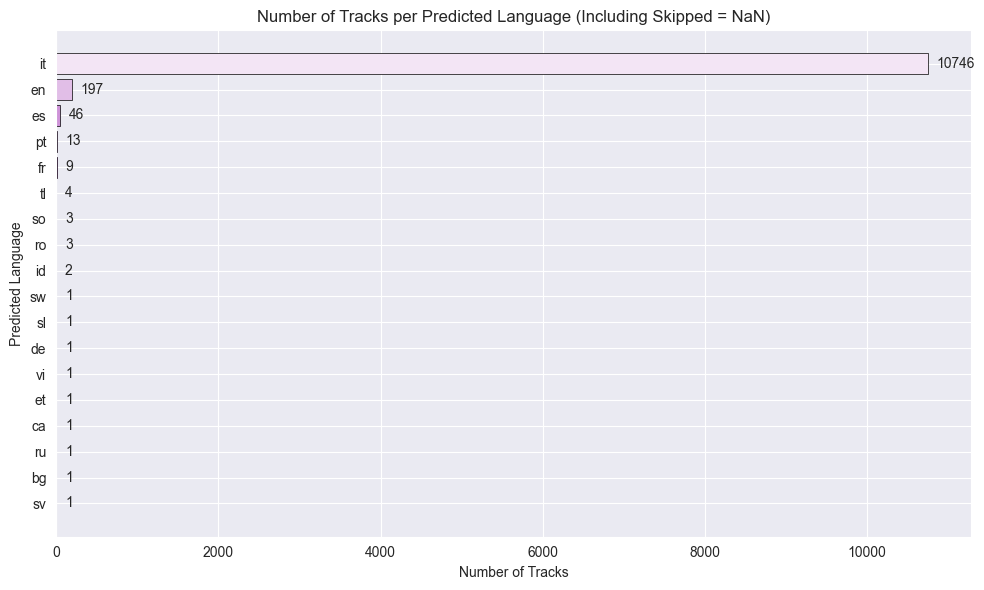

In [32]:
from itertools import cycle, islice

# --- 1) Conta lingue includendo i NaN
lang_counts = df['language'].value_counts(dropna=False).reset_index()
lang_counts.columns = ['language', 'count']

# Mostra "NaN" come etichetta senza toccare df
lang_counts['language'] = lang_counts['language'].astype(object).where(
    ~lang_counts['language'].isna(), 'NaN'
)

# Ordina per count decrescente
lang_counts = lang_counts.sort_values('count', ascending=False).reset_index(drop=True)

# --- 2) Palette (simile all'Altair che avevi)
base_palette = ["#f3e5f5", "#e1bee7", "#ce93d8", "#ba68c8", "#9c27b0"]
# se le categorie sono più di 5, cicla i colori
palette = list(islice(cycle(base_palette), len(lang_counts)))

# --- 3) Plot (barh ordinato)
plt.figure(figsize=(10, 6))
bars = plt.barh(
    y=lang_counts['language'],
    width=lang_counts['count'],
    color=palette,
    edgecolor='black',
    linewidth=0.5
)

# Inverti asse Y per avere la lingua più frequente in alto
plt.gca().invert_yaxis()

plt.xlabel('Number of Tracks')
plt.ylabel('Predicted Language')
plt.title('Number of Tracks per Predicted Language (Including Skipped = NaN)')

# --- 4) Aggiungi etichette con i conteggi alla fine delle barre
for bar, val in zip(bars, lang_counts['count']):
    x = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2
    plt.text(x + max(lang_counts['count']) * 0.01, y, str(val), va='center')

plt.tight_layout()
plt.show()

In [53]:
display(df.loc[df['language']== "en", ['full_title', 'lyrics', 'language',]].head(50))

,full_title,lyrics,language
41,3SOME by Rosa Chemical (Ft. VillaBanks),"È Rosa Chemical, ahahah\nVat'la piè 'nta 'l cu...",en
254,Thalloween by thasup (Ft. ​​yungest Moonstar),"Thalloween, Thalloween, Thalloween, Tha'\n\nTh...",en
288,Mad world con le righe delle lacrime sulle gua...,All around me are familiar faces\nWorn-out pla...,en
291,Shawty by Yung Snapp (Ft. ANNA),"Yung Snapp made another hit\nMhm, quando sto c...",en
376,PUTO by Lazza (Ft. French Montana),You know what it is\nLazza\nWhen you hear that...,en
423,"The Exchange by Lazza, Murda, Beny Jr, Guy2Bez...","Hey, Keys, what's up?\nAyo, what's up Migo?\nL...",en
730,Jabbering by Babaman (Ft. Kane Juice),Oh well this is jabbering\nOh well this is jab...,en
866,Dem Fake by Guè (Ft. Alborosie),"6 on the beat\n\nDem fake, dem fake, dem fake\...",en
880,Sponsor by Guè (Ft. Dutchavelli),"Rvchet, so I move and I get Rvchet\n(My guns g...",en
885,Nicolas Cage by Guè (Ft. Jadakiss),"Sì, sì, Suntory nella mia ugola\nBitch, googla...",en


In [59]:
df.loc[[41, 291, 376, 730, 866, 880, 885, 952, 963, 1006, 1035, 1049, 1061, 1065, 1194, 1264, 1285, 1483,1722, 1735, 1842, 1945, 2500, 2557,2572, 2602, 2904, 2963, 3007, 3017, 3034, 3045,3069,3096, 3266, 3404, 3503, 3516, 3924, 4301, 4367,4886, 5003, 5005, 5007, 5008, 5034, 5050, 5053, 5069, 5076, 5081, 5234, 6777,7474, 7720, 8967, 8981, 9214, 9229, 9727, 9920, 9985, 10432], "predicted_language"] = "it"

display(df.loc[df['language']== "en", ['name', 'lyrics', 'language',]].head(50))

,name,lyrics,language
41,rosa chemical,"È Rosa Chemical, ahahah\nVat'la piè 'nta 'l cu...",en
254,thasup,"Thalloween, Thalloween, Thalloween, Tha'\n\nTh...",en
288,thasup,All around me are familiar faces\nWorn-out pla...,en
291,yung snapp,"Yung Snapp made another hit\nMhm, quando sto c...",en
376,lazza,You know what it is\nLazza\nWhen you hear that...,en
423,lazza,"Hey, Keys, what's up?\nAyo, what's up Migo?\nL...",en
730,babaman,Oh well this is jabbering\nOh well this is jab...,en
866,guè pequeno,"6 on the beat\n\nDem fake, dem fake, dem fake\...",en
880,guè pequeno,"Rvchet, so I move and I get Rvchet\n(My guns g...",en
885,guè pequeno,"Sì, sì, Suntory nella mia ugola\nBitch, googla...",en


In [61]:
df.loc[[3601], "predicted_language"] = "it"

display(df.loc[df['language']== "es", ['name', 'lyrics', 'language',]].head(50))

,name,lyrics,language
665,nerone,Te lo cuento aquí sentado mientras me escuchas...,es
738,babaman,violence\n rastaman\nI don't,es
909,guè pequeno,"Ragga, ragga\nEsto es como un ragga muffin, pe...",es
1381,skioffi,Ella es la protagonista de esta historia\nY el...,es
1491,mahmood,Te digo que el amor es como el crimen nunca pa...,es
1524,piotta,"Norte, sur, oeste, este\nRoma es, así de grand...",es
2256,rocco hunt,Ana Mena\nDesde Málaga pa'l mundo\nPoeta Urban...,es
2342,rocco hunt,"Ey, Ana Mena\nDesde Málaga pa'l mundo\nPoeta U...",es
2359,rocco hunt,Te quería decir hace tiempo\nPero nunca he enc...,es
2374,rocco hunt,Lola Indigo\nElettra\nPoeta Urbano\nElettra La...,es


#### Correcting wrong active start
Upon Inspection on the age of the artists when they started their career (code above).

Among the unique artists, several had unusual ages at career start.  Nesli (age 10)  had incorrect active start dates, while  Salmo (age 13) and Mudimbi (age 27) are correct.  These values comes from the original data.

After filling birthdate and Active start date we realized that (bigmama) started at the age of one which is obviously wrong.

We have age (7) it was for the singer priestess, but we already corrected its data above in the section (Correcting "Priestess" Entry).

 We will correct the errors by updating  Nesli’s to 1999,bigmama to 2016, leaving Salmo and Mudimbi unchanged.

In [35]:
# Calculate age at career start without adding a column
ages = df['active_start'].dt.year - df['birth_date'].dt.year

# Filter rows where age is 1,7  10,  13,or 27
outliers = df[ages.isin([1,7 ,10, 13,27,])].copy()

# Keep only unique artists based on name
unique_outliers = outliers.drop_duplicates(subset=['name'])

print(unique_outliers[['name', 'birth_date', 'active_start']].assign(age_at_start=ages))

         name birth_date active_start  age_at_start
1128  mudimbi 1986-10-17   2013-01-01          27.0
6458  bigmama 2000-03-10   2001-01-01           1.0
6645    nesli 1980-12-29   1990-01-01          10.0
9608    salmo 1984-06-29   1997-01-01          13.0


         name birth_date active_start
6458  bigmama 2000-03-10   2016-01-01
6459  bigmama 2000-03-10   2016-01-01
6460  bigmama 2000-03-10   2016-01-01
6461  bigmama 2000-03-10   2016-01-01
6462  bigmama 2000-03-10   2016-01-01
...       ...        ...          ...
9788    salmo 1984-06-29   1997-01-01
9789    salmo 1984-06-29   1997-01-01
9791    salmo 1984-06-29   1997-01-01
9792    salmo 1984-06-29   1997-01-01
9793    salmo 1984-06-29   1997-01-01

[380 rows x 3 columns]
Age of unique Artists When They Started Their Career After Filling Missing Values and Correcting Errors
13    1
14    3
15    4
16    2
17    8
18    8
19    4
20    5
21    5
22    3
23    1
24    1
27    1
Name: count, dtype: int64


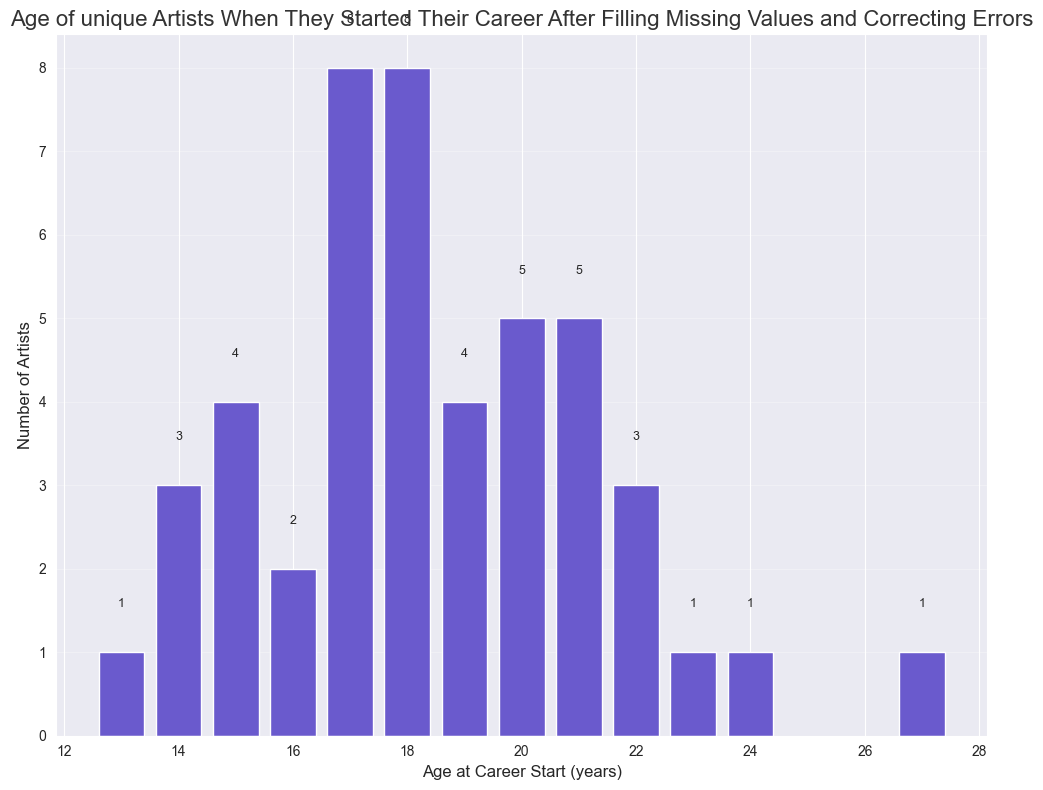

In [36]:
# Correcting wrong active_start dates
df.loc[df['name'] == 'bigmama', 'active_start'] = pd.to_datetime('2016-01-01')
df.loc[df['name'] == 'nesli', 'active_start'] = pd.to_datetime('1999-01-01')

# Verify the changes
outliers_corrected = df[df['name'].isin(['bigmama', 'nesli', 'salmo',])]
print(outliers_corrected[['name', 'birth_date', 'active_start']])
functions.plot_age_at_career_start(df,'Age of unique Artists When They Started Their Career After Filling Missing Values and Correcting Errors')

#### Correcting album release dates for albums that have multiple release dates

In [37]:
# --- 1. Make sure album_release_date is a datetime type ---
df['album_release_date'] = pd.to_datetime(df['album_release_date'], errors='coerce')

# --- 2. Compute the oldest (earliest) date per album ---
earliest_dates = (
    df.groupby('album_name', as_index=False)['album_release_date']
    .min()
)

# --- 3. Merge back into the main dataframe ---
df = df.drop(columns=['album_release_date']).merge(
    earliest_dates,
    on='album_name',
    how='left'
)

# --- 4. Confirm result ---
print("Replaced albums with multiple release dates by their earliest (oldest) date.")
print(df[['album_name', 'album_release_date']].drop_duplicates().shape)
display(df[['album_name', 'album_release_date']].drop_duplicates())


Replaced albums with multiple release dates by their earliest (oldest) date.
(2405, 2)


,album_name,album_release_date
0,FOREVER AND EVER,2021-04-09
3,OKAY OKAY 2,2025-05-16
4,FOREVER,2020-05-28
8,MADE IN ITALY,2023-02-09
10,POLKA 3,2022-06-02
...,...,...
10948,"NOI, LORO, GLI ALTRI (Deluxe)",2022-12-09
10986,LA BANALITÀ DEL MALE (End credit song “Qui non...,2024-11-06
10997,La Tipa Del Tipo,2013-01-01
11016,Monument,2018-12-07


### Save new cleaned dataset

In [38]:
output_folder = "data"
output_file = "merge_dataset_cleaned.csv"
output_filename = os.path.join(output_folder, output_file)

print(f"--- Saving Cleaned DataFrame ---")
print(f"Saving {len(df)} rows and {len(df.columns)} columns to '{output_filename}'...")

try:
    df.to_csv(output_filename, index=False)

    print(f"\nSUCCESS: DataFrame saved successfully to '{output_filename}'.")

except Exception as e:
    print(f"\nERROR: An error occurred while saving the file.")
    print(f"Error details: {e}")

--- Saving Cleaned DataFrame ---
Saving 11032 rows and 53 columns to 'data\merge_dataset_cleaned.csv'...

SUCCESS: DataFrame saved successfully to 'data\merge_dataset_cleaned.csv'.


### Multivatiate Analysis

In [39]:
# Numerical Feature Definition

# List of key numerical columns to analyze
skewed_features = [
    'tokens_per_sent', 'duration_ms', 'stats_pageviews', 'swear_EN', 'char_per_tok', 'swear_IT', 'bpm', 'n_sentences', 'n_tokens', 'rolloff', 'zcr', 'lexical_density', 'flatness'
]

simetric_features =[
    'pitch', 'centroid', 'spectral_complexity', 'loudness', 'flux', 'rms'
]

In [40]:
numerical_features = skewed_features + simetric_features

# Ensure there are no NaNs (should be clean already)
df_analysis = df[numerical_features].dropna()
print(f"Data ready for analysis: {df_analysis.shape}")

scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_analysis)

# Applying Isolation Forest
iso_forest = IsolationForest(contamination=0.02, random_state=42)

# We train and get the predictions
# The algorithm assigns:
#  1 for Inliers (normal points)
# -1 for Outliers (anomalous points)
predictions = iso_forest.fit_predict(data_scaled)

df_analysis['is_outlier_multi'] = predictions

df['is_outlier_multi'] = df_analysis['is_outlier_multi'].reindex(df.index)

outliers_multi = df[df['is_outlier_multi'] == -1]
print(f"\nAnalysis completed.")
print(f"Number of multivariate outliers identified: {len(outliers_multi)}")

# Show some of the records identified as anomalous
print("\nExamples of Multivariate Outliers:")

# Show the original columns and our clean columns
display(outliers_multi[['full_title', 'primary_artist'] + numerical_features].head())

Data ready for analysis: (4634, 19)

Analysis completed.
Number of multivariate outliers identified: 93

Examples of Multivariate Outliers:


,full_title,primary_artist,tokens_per_sent,duration_ms,stats_pageviews,swear_EN,char_per_tok,swear_IT,bpm,n_sentences,...,rolloff,zcr,lexical_density,flatness,pitch,centroid,spectral_complexity,loudness,flux,rms
0,​polka 2 :-/ by Rosa Chemical (Ft. Ernia & Guè),Rosa Chemical,6.882353,207761.0,196033.0,6,4.133903,13,135.32,102,...,2895.7767,0.1046,0.562678,0.8202,2311.1779,0.1858,25.7148,17.8675,1.4499,0.1786
1,POLKA by Rosa Chemical (Ft. Thelonious B.),Rosa Chemical,8.275862,207761.0,164450.0,12,4.093750,9,129.37,58,...,3378.4605,0.1175,0.506250,0.6739,1892.1924,0.2071,29.1089,21.4595,1.3533,0.2020
15,RAF SIMONS by Rosa Chemical,Rosa Chemical,6.214286,61922.0,12590.0,0,4.109195,1,96.27,28,...,2984.9233,0.1058,0.724138,0.7965,2487.1039,0.1904,39.8208,30.4793,1.3750,0.2683
22,Freestyle #redbullnext #essemagazine by Rosa C...,Rosa Chemical,5.875000,169000.0,7444.0,1,4.542553,0,164.08,16,...,1573.9462,0.0560,0.531915,0.6427,1327.9784,0.1165,31.8730,43.8683,1.3346,0.3519
23,Scolapasta by Rosa Chemical,Rosa Chemical,3.830986,138560.0,5071.0,0,4.500000,4,132.01,71,...,3034.3304,0.1035,0.477941,0.7277,2366.3715,0.1898,13.9209,9.9063,1.3105,0.1101


It identified the 93 (2%) songs that are the most stylistically unique when combining all 21 features.
The examples show two clear patterns:

Lyrical Anomalies (Rosa Chemical): This artist is flagged repeatedly. The data shows his songs have a very rare combination: they are lyrically complex (avg_token_per_clause_log, lexical_density) AND have high profanity in both Italian and English (swear_IT_log, swear_EN_log). This makes them stand out from all other artists.

Audio Anomalies (thasup): The "thasup" track is a perfect example of an audio outlier. It has a very slow bpm (82) but is at the maximum loudness (45) and maximum pitch (3191). This combination of "slow, loud, and high-pitched" is a very unusual audio profile.

Conclusion: These 93 songs are "stylistic outliers" (like experimental tracks). They are not errors, but you should remove them before clustering to get clearer, more representative clusters of the main "rap schools".

In [41]:
# We use PCA to reduce the dimension and be able to plot the outliers

# Reduce the scaled data to 2 dimensions
pca = SklearnPCA(n_components=2, random_state=42)
data_scaled_2d = pca.fit_transform(data_scaled)

# Create a DataFrame for plotting
plot_df = pd.DataFrame(data_scaled_2d, columns=['PC1', 'PC2'])
plot_df['Type'] = np.where(predictions == -1, 'Outlier (-1)', 'Inlier (1)')

plot_df['original_index'] = df_analysis.index
plot_df = plot_df.merge(df[['full_title', 'primary_artist']], left_on='original_index', right_index=True, how='left')

# Create Altair Scatter Plot
chart = alt.Chart(plot_df).mark_circle(opacity=0.6).encode(
    x=alt.X('PC1', title='Principal Component 1'),
    y=alt.Y('PC2', title='Principal Component 2'),

    color=alt.Color('Type',
                    scale=alt.Scale(domain=['Outlier (-1)', 'Inlier (1)'],
                                    range=['red', 'blue'])),

    tooltip=['full_title', 'primary_artist', 'PC1', 'PC2', 'Type']

).properties(
    title='Isolation Forest Results (visualized with PCA)'
).interactive()

display(chart)

alt.Chart(...)

### Correlation Analysis

 In this section we:
 - select numeric columns
 - compute Pearson and Spearman correlation matrices
 - detect highly correlated pairs (potentially redundant features)

In [42]:
# Select only numeric columns (optionally exclude IDs)
id_like = {"id", "id_track", "id_album", "id_album_clean", "id_artist"}
num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in id_like]

print("Numeric columns used:", num_cols)

Numeric columns used: ['stats_pageviews', 'swear_IT', 'swear_EN', 'month', 'day', 'bpm', 'centroid', 'rolloff', 'flux', 'rms', 'zcr', 'flatness', 'spectral_complexity', 'pitch', 'loudness', 'disc_number', 'track_number', 'duration_ms', 'popularity', 'latitude', 'longitude', 'popularity_missing_flag', 'n_tokens', 'n_sentences', 'lexical_density', 'tokens_per_sent', 'char_per_tok', 'is_outlier_multi']


#### Pearson correlation (linear relationships)

In [43]:
# =========================
# Column filters for Pearson
# =========================
id_like = {"id", "id_track", "id_album", "id_album_clean", "id_artist"}

# =========================
# 1) Select numeric candidates (exclude id-like)
# =========================
num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in id_like]

excluded = {}
kept = []

for c in num_cols:
    s = df[c]
    reasons = []
    if pd.api.types.is_bool_dtype(s) or functions.is_binary_series(s):
        reasons.append("binary/bool → use point-biserial (not raw Pearson)")
    if functions.is_low_cardinal_int(s, max_levels=5):
        reasons.append("low-cardinality ordinal → prefer Spearman/Kendall")
    if functions.is_quasi_constant(s):
        reasons.append("quasi-constant → variance ~ 0")
    if functions.is_extreme_zeroinflated_count(s):
        reasons.append("extreme zero-inflated count")
    if reasons:
        excluded[c] = "; ".join(reasons)
    else:
        kept.append(c)

print("Columns kept for Pearson:", kept)
if excluded:
    print("\nColumns excluded and reason:")
    for k, v in excluded.items():
        print(f"- {k}: {v}")

# =========================
# 2) Pearson correlation (only 'kept' columns)
# =========================
if len(kept) < 2:
    raise ValueError("Too many columns excluded: fewer than 2 columns suitable for Pearson.")

pearson_corr = df[kept].corr(method="pearson")
print("\nPearson correlation (filtered):")
print(pearson_corr)

# =========================
# 3) Strong correlations (pair list, NOT matrix)
# =========================
threshold = 0.9  # adjust as needed

upper_mask = np.triu(np.ones(pearson_corr.shape), k=1).astype(bool)
pairs = (
    pearson_corr.where(upper_mask)
    .stack()
    .reset_index()
)
pairs.columns = ["feature_1", "feature_2", "pearson_r"]

strong_pearson = (
    pairs[pairs["pearson_r"].abs() >= threshold]
    .sort_values(by="pearson_r", key=lambda s: s.abs(), ascending=False)
)
print(f"\nStrong Pearson pairs (|r| >= {threshold}):")
print(strong_pearson if not strong_pearson.empty else "None")


Columns kept for Pearson: ['stats_pageviews', 'swear_IT', 'swear_EN', 'month', 'day', 'bpm', 'centroid', 'rolloff', 'flux', 'rms', 'zcr', 'flatness', 'spectral_complexity', 'pitch', 'loudness', 'track_number', 'duration_ms', 'popularity', 'latitude', 'longitude', 'n_tokens', 'n_sentences', 'lexical_density', 'tokens_per_sent', 'char_per_tok']

Columns excluded and reason:
- disc_number: quasi-constant → variance ~ 0
- popularity_missing_flag: binary/bool → use point-biserial (not raw Pearson); low-cardinality ordinal → prefer Spearman/Kendall; quasi-constant → variance ~ 0; extreme zero-inflated count
- is_outlier_multi: quasi-constant → variance ~ 0

Pearson correlation (filtered):
                     stats_pageviews  swear_IT  swear_EN     month       day  \
stats_pageviews             1.000000  0.027614 -0.016505  0.042345 -0.007139   
swear_IT                    0.027614  1.000000  0.102235  0.015612  0.024972   
swear_EN                   -0.016505  0.102235  1.000000  0.002017  

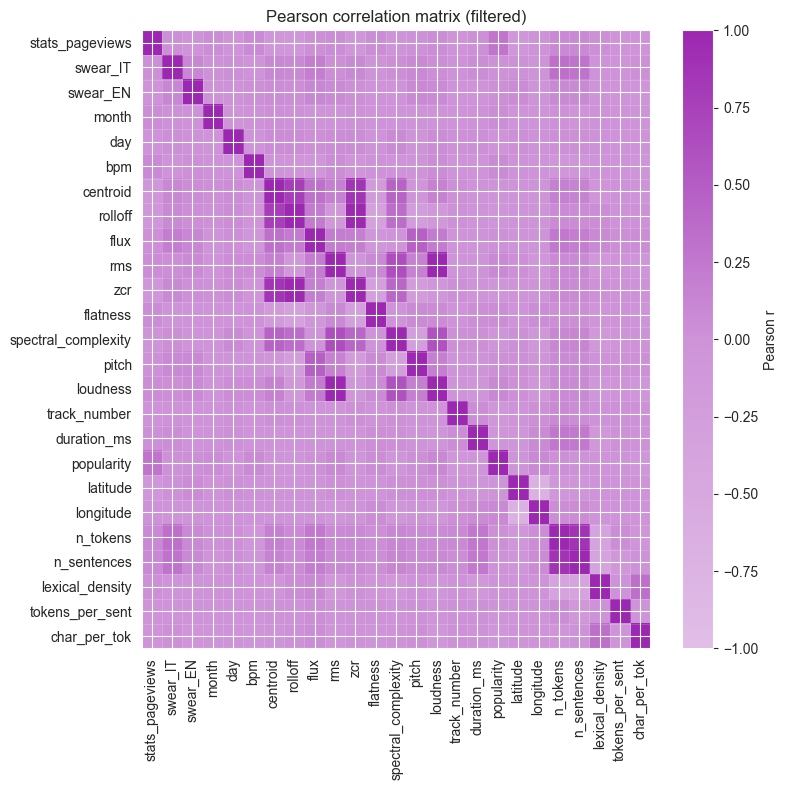

In [44]:
# ===== Custom palette =====

hex_colors = ["#e1bee7", "#ce93d8", "#9c27b0"]  # your colors
cmap_custom = LinearSegmentedColormap.from_list("custom_purple", hex_colors)

# =========================
# Heatmap (Pearson matrix) with custom colors
# =========================
# Uses the same column order as `kept`
corr_mat = pearson_corr.loc[kept, kept]

# Mask NaNs to show as empty cells
data = np.ma.masked_invalid(corr_mat.to_numpy())

plt.figure(figsize=(8, 8))
# TwoSlopeNorm centers the color at 0, with vmin=-1, vmax=1
norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
im = plt.imshow(data, aspect="auto", norm=norm, cmap=cmap_custom)
plt.colorbar(im, label="Pearson r")

plt.xticks(ticks=np.arange(len(kept)), labels=kept, rotation=90)
plt.yticks(ticks=np.arange(len(kept)), labels=kept)

# Optional grid
ax = plt.gca()
ax.set_xticks(np.arange(-.5, len(kept), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(kept), 1), minor=True)
ax.grid(which="minor", linestyle="-", linewidth=0.5, alpha=0.25)
ax.tick_params(which="minor", bottom=False, left=False)

plt.title("Pearson correlation matrix (filtered)")
plt.tight_layout()
plt.show()


#### Spearman correlation (monotonic relationships, robust to outliers)

In [45]:
# =========================
# Column filters for Spearman + Pearson vs Spearman comparison
# =========================

id_like = {"id", "id_track", "id_album", "id_album_clean", "id_artist"}

# Variables typically circular (Spearman is not recommended for cyclic relationships)
circular_names = {"month", "day", "weekday", "dow", "hour", "minute", "second"}

# =========================
# 1) Select numeric candidates for Spearman (keep ordinal/binary, exclude id-like)
# =========================
num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in id_like]

excluded_s = {}
kept_s = []
spearman_soft_warn = {}

for c in num_cols:
    s = df[c]
    reasons = []
    # Hard exclusions for Spearman suitability
    if functions.is_quasi_constant(s) or s.dropna().nunique() < 2:
        reasons.append("constant/nearly-constant or <2 distinct non-null values")
    if c.lower() in circular_names:
        reasons.append("circular variable (cyclic) — Spearman not suitable")
    if reasons:
        excluded_s[c] = "; ".join(reasons)
        continue

    # Keep the column
    kept_s.append(c)

    # Soft warnings (still kept, but flagged)
    warns = []
    if pd.api.types.is_integer_dtype(s) and (s >= 0).all() and (s == 0).mean() >= 0.95:
        warns.append("extreme zero-inflation (many ties) — Kendall τ-b or transformations may be better")
    if warns:
        spearman_soft_warn[c] = "; ".join(warns)

print("Columns kept for Spearman:", kept_s)
if excluded_s:
    print("\nColumns excluded for Spearman (hard) and reason:")
    for k, v in excluded_s.items():
        print(f"- {k}: {v}")
if spearman_soft_warn:
    print("\nColumns where Spearman is NOT recommended (soft warning):")
    for k, v in spearman_soft_warn.items():
        print(f"- {k}: {v}")

# =========================
# 2) Spearman correlation (only 'kept_s' columns)
# =========================
if len(kept_s) < 2:
    raise ValueError("Too few columns for Spearman: need at least 2 usable columns.")

# Use min_periods to reduce all-NaN issues with sparse overlap
spearman_corr = df[kept_s].corr(method="spearman", min_periods=3)
print("\nSpearman correlation (filtered):")
print(spearman_corr)

# =========================
# 3) Strong correlations (pair list, NOT matrix)
# =========================
threshold = 0.9  # adjust as needed

upper_mask_s = np.triu(np.ones(spearman_corr.shape), k=1).astype(bool)
pairs_s = (
    spearman_corr.where(upper_mask_s)
    .stack()
    .reset_index()
)
pairs_s.columns = ["feature_1", "feature_2", "spearman_rho"]

strong_spearman = (
    pairs_s[pairs_s["spearman_rho"].abs() >= threshold]
    .sort_values(by="spearman_rho", key=lambda s: s.abs(), ascending=False)
)

print(f"\nStrong Spearman pairs (|rho| >= {threshold}):")
print(strong_spearman if not strong_spearman.empty else "None")

# =========================
# 4) Pearson vs Spearman comparison on common pairs
#    (requires you already computed `pearson_corr` and `strong_pearson`)
# =========================
def _pairs_from_corr(corr_df: pd.DataFrame, val_name: str) -> pd.DataFrame:
    """Stack upper triangle of a correlation matrix into a tidy pair list."""
    mask = np.triu(np.ones(corr_df.shape), k=1).astype(bool)
    out = (
        corr_df.where(mask)
        .stack()
        .reset_index()
    )
    out.columns = ["feature_1", "feature_2", val_name]
    # Ensure consistent pair ordering (feature_1 < feature_2) to merge reliably
    ordered = out.apply(
        lambda r: pd.Series(sorted([r["feature_1"], r["feature_2"]]) + [r[val_name]]),
        axis=1
    )
    ordered.columns = ["f1", "f2", val_name]
    return ordered

try:
    # Intersect the variable sets so we're comparing apples to apples
    common_cols = sorted(set(pearson_corr.columns).intersection(set(spearman_corr.columns)))
    if len(common_cols) >= 2:
        p_pairs = _pairs_from_corr(pearson_corr.loc[common_cols, common_cols], "pearson_r")
        s_pairs = _pairs_from_corr(spearman_corr.loc[common_cols, common_cols], "spearman_rho")
        comp = p_pairs.merge(s_pairs, on=["f1", "f2"], how="inner")
        comp["abs_delta"] = (comp["pearson_r"] - comp["spearman_rho"]).abs()
        comp["sign_disagreement"] = np.sign(comp["pearson_r"]) != np.sign(comp["spearman_rho"])

        # Sort by absolute delta descending
        comp_sorted = comp.sort_values("abs_delta", ascending=False).reset_index(drop=True)

        print("\nPearson vs Spearman comparison (common pairs):")
        print(comp_sorted.head(30).to_string(index=False))

        # Optional: also show only sign disagreements
        comp_sign_flip = comp_sorted[comp_sorted["sign_disagreement"]]
        if not comp_sign_flip.empty:
            print("\nPairs with SIGN DISAGREEMENT between Pearson and Spearman:")
            print(comp_sign_flip.head(30).to_string(index=False))

        # Expose for later use (e.g., plotting)
        comparison_table = comp_sorted.copy()
    else:
        print("\nNot enough common columns for comparison.")
except NameError:
    print("\n`pearson_corr` not found. Run the Pearson block first to enable the comparison.")


Columns kept for Spearman: ['stats_pageviews', 'swear_IT', 'swear_EN', 'bpm', 'centroid', 'rolloff', 'flux', 'rms', 'zcr', 'flatness', 'spectral_complexity', 'pitch', 'loudness', 'track_number', 'duration_ms', 'popularity', 'latitude', 'longitude', 'n_tokens', 'n_sentences', 'lexical_density', 'tokens_per_sent', 'char_per_tok']

Columns excluded for Spearman (hard) and reason:
- month: circular variable (cyclic) — Spearman not suitable
- day: circular variable (cyclic) — Spearman not suitable
- disc_number: constant/nearly-constant or <2 distinct non-null values
- popularity_missing_flag: constant/nearly-constant or <2 distinct non-null values
- is_outlier_multi: constant/nearly-constant or <2 distinct non-null values

Spearman correlation (filtered):
                     stats_pageviews  swear_IT  swear_EN       bpm  centroid  \
stats_pageviews             1.000000  0.039990  0.016341  0.079708 -0.078919   
swear_IT                    0.039990  1.000000  0.221601 -0.022343  0.134879  

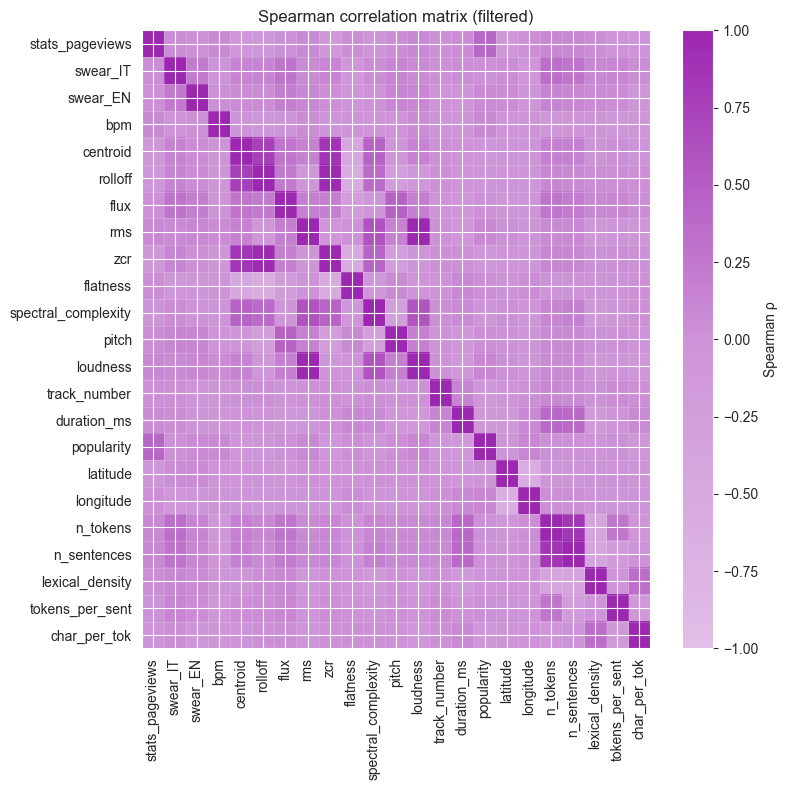

In [46]:
# Custom palette
cmap_custom = LinearSegmentedColormap.from_list("custom_purple", hex_colors)

# Ensure same column order as kept_s
corr_mat_s = spearman_corr.loc[kept_s, kept_s]

# Mask NaNs so they appear as empty cells
data_s = np.ma.masked_invalid(corr_mat_s.to_numpy())

plt.figure(figsize=(8, 8))
norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)  # center color at 0
im = plt.imshow(data_s, aspect="auto", norm=norm, cmap=cmap_custom)
plt.colorbar(im, label="Spearman ρ")

plt.xticks(ticks=np.arange(len(kept_s)), labels=kept_s, rotation=90)
plt.yticks(ticks=np.arange(len(kept_s)), labels=kept_s)

# Optional grid to separate cells
ax = plt.gca()
ax.set_xticks(np.arange(-.5, len(kept_s), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(kept_s), 1), minor=True)
ax.grid(which="minor", linestyle="-", linewidth=0.5, alpha=0.25)
ax.tick_params(which="minor", bottom=False, left=False)

plt.title("Spearman correlation matrix (filtered)")
plt.tight_layout()
plt.show()

The two heatmaps display the Pearson and Spearman correlation matrices after filtering the dataset. In both cases, correlations are generally weak, indicating that the majority of variables are largely independent. Only small clusters of moderate correlation appear among acoustic features such as spectral centroid, rolloff, flux, flatness, and spectral complexity, which is expected since they describe related timbral properties. Linguistic features show minimal association with acoustic and popularity-related variables, and metrics like popularity, pageviews, and the two swearing indicators exhibit almost no meaningful relationship with the rest of the features. The similarity between the Pearson and Spearman matrices suggests that even non-linear monotonic trends are limited. Overall, the dataset shows low redundancy, with only a few mild correlations confined to subsets of acoustically related features.

###  Distance & similarity measures

 In this section we compute different distance/similarity matrices  on the numeric features to support clustering and nearest-neighbor analysis.


In [47]:
# Riutilizziamo num_cols definiti prima.
# Se non li hai ancora:
id_like = {"id", "id_track", "id_album", "id_album_clean", "id_artist"}
num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in id_like]

print("Numeric columns used for distances:", num_cols)

# Standardizzazione (z-score)
scaler = StandardScaler()
X_num = scaler.fit_transform(df[num_cols])

X_num_df = pd.DataFrame(X_num, columns=num_cols)
display(X_num_df.head())

Numeric columns used for distances: ['stats_pageviews', 'swear_IT', 'swear_EN', 'month', 'day', 'bpm', 'centroid', 'rolloff', 'flux', 'rms', 'zcr', 'flatness', 'spectral_complexity', 'pitch', 'loudness', 'disc_number', 'track_number', 'duration_ms', 'popularity', 'latitude', 'longitude', 'popularity_missing_flag', 'n_tokens', 'n_sentences', 'lexical_density', 'tokens_per_sent', 'char_per_tok', 'is_outlier_multi']


,stats_pageviews,swear_IT,swear_EN,month,day,bpm,centroid,rolloff,flux,rms,...,popularity,latitude,longitude,popularity_missing_flag,n_tokens,n_sentences,lexical_density,tokens_per_sent,char_per_tok,is_outlier_multi
0,2.722934,2.858621,2.054948,-0.635977,-1.561559,0.789705,1.717443,2.250453,1.398239,-0.716000,...,0.658830,0.74924,-1.412002,-0.050443,1.539025,1.691297,0.372006,-0.107779,0.129737,-6.987700
1,2.182177,1.782829,4.389953,-0.923336,-1.110173,0.567795,2.478131,3.101262,0.687332,-0.351615,...,0.658830,0.74924,-1.412002,-0.050443,0.261688,-0.102802,-0.118449,0.149029,-0.001417,-6.987700
2,0.364924,3.665466,4.389953,-1.210696,0.356834,0.728540,1.628161,0.737573,0.900015,0.476814,...,0.307856,0.74924,-1.412002,-0.050443,0.963648,1.120447,-0.201648,-0.115417,-0.372747,0.143109
3,0.049490,1.513881,0.887445,-0.923336,-0.884479,1.792964,-1.175313,-0.815522,2.134168,-0.427918,...,0.708969,0.74924,-1.412002,-0.050443,-0.618639,-0.959077,0.770822,0.252595,-0.177783,0.143109
4,-0.026839,-0.368755,-0.280058,-0.348618,1.485301,-0.308658,0.156783,0.131163,-1.260672,0.191847,...,0.408134,0.74924,-1.412002,-0.050443,-0.486303,-0.510552,0.050729,-0.032347,-0.662269,0.143109


#### Euclidean distance

Standard choice for numeric features (after scaling). Used in k-means and many clustering methods.

[Info] Full distance matrix size ~0.91 GB for n=11032. Consider subsampling for very large n.
Diag max=0.000e+00 (should be ~0), symmetry max diff=4.441e-16 (should be ~0)


,0,1,2,3,4,5,6,7,8,9
0,0.000000,0.412940,0.992868,1.304618,1.514998,1.610168,1.189742,1.120392,1.201663,1.374477
1,0.412940,0.000000,0.943135,1.379205,1.395813,1.600509,1.178492,0.962181,1.098593,1.250602
2,0.992868,0.943135,0.000000,1.142803,1.460240,1.544054,0.850249,0.539414,1.125784,1.084005
3,1.304618,1.379205,1.142803,0.000000,1.666948,1.452843,1.388727,1.361532,1.575763,1.403932
4,1.514998,1.395813,1.460240,1.666948,0.000000,0.910481,1.144570,1.271267,1.086766,0.975795
5,1.610168,1.600509,1.544054,1.452843,0.910481,0.000000,1.277510,1.490317,1.448463,1.173628
6,1.189742,1.178492,0.850249,1.388727,1.144570,1.277510,0.000000,0.877598,0.769913,0.834924
7,1.120392,0.962181,0.539414,1.361532,1.271267,1.490317,0.877598,0.000000,1.039853,0.967634
8,1.201663,1.098593,1.125784,1.575763,1.086766,1.448463,0.769913,1.039853,0.000000,1.021854
9,1.374477,1.250602,1.084005,1.403932,0.975795,1.173628,0.834924,0.967634,1.021854,0.000000


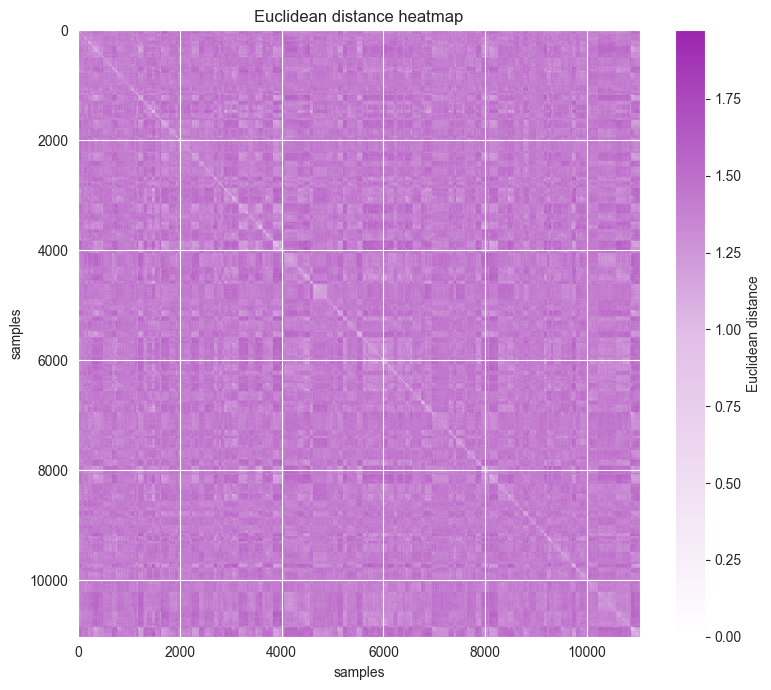

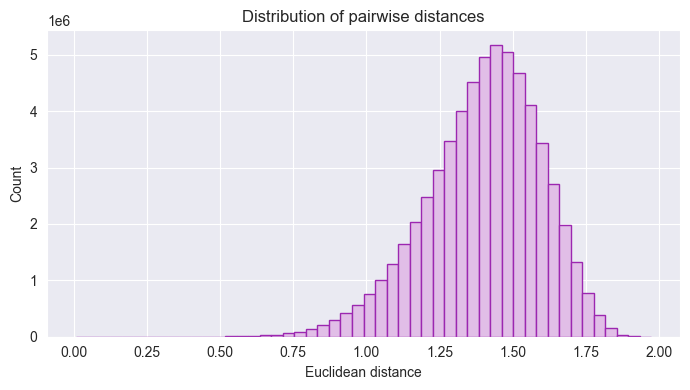

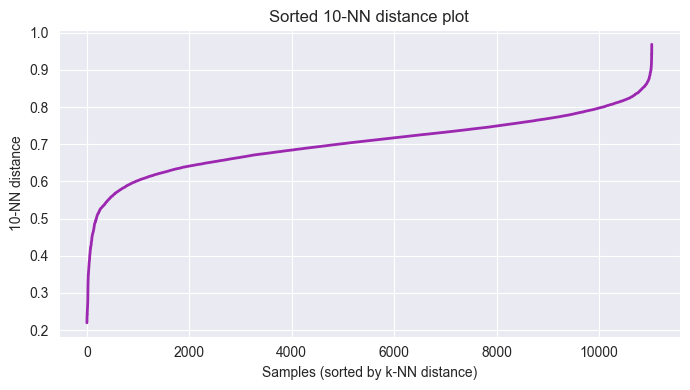

In [52]:
# --- Custom colors ---
hex_colors = ["#ffffff", "#e1bee7", "#9c27b0"]
cmap_custom = LinearSegmentedColormap.from_list("custom3", hex_colors)

X_sub = X_num  # <-- no subsampling

# (Optional) memory warning: full distance matrix is n x n
n = X_sub.shape[0]
bytes_per = 8  # float64 by default
est_gb = (n * n * bytes_per) / (1024**3)
if est_gb > 0.5:
    print(f"[Info] Full distance matrix size ~{est_gb:.2f} GB for n={n}. "
          "Consider subsampling for very large n.")

# Light diagnostics: rows where Euclidean is NOT ideal
row_has_bad = ~np.isfinite(X_sub).all(axis=1)
row_zero_ratio = (X_sub == 0).sum(axis=1) / np.maximum(1, X_sub.shape[1])
row_too_sparse = row_zero_ratio >= 0.95  # tweak threshold if needed
bad_idx = np.where(row_has_bad | row_too_sparse)[0]
if bad_idx.size:
    print(f"[Warning] {bad_idx.size} rows may be unsuitable for Euclidean distance.")
    print(" - Reasons: NaN/Inf or extreme sparsity (>=95% zeros). Consider cosine/Jaccard or imputation/scaling.")
    print(" - Example indices:", bad_idx[:20].tolist(), ("..." if bad_idx.size > 20 else ""))

# Minimal NaN handling BEFORE distances (drop all-NaN cols + median-impute)
col_nan_counts = np.isnan(X_sub).sum(axis=0)
all_nan_cols = np.where(col_nan_counts == X_sub.shape[0])[0]
if all_nan_cols.size:
    print(f"Dropping {all_nan_cols.size} all-NaN columns:", all_nan_cols[:20].tolist(),
          ("..." if all_nan_cols.size > 20 else ""))
    X_sub = np.delete(X_sub, all_nan_cols, axis=1)

if np.isnan(X_sub).any():
    print("Median-imputing remaining NaN values column-wise.")
    X_sub = SimpleImputer(strategy="median").fit_transform(X_sub)

# Euclidean distance matrix (unchanged logic)
dist_euclidean = pairwise_distances(X_sub, metric="euclidean")

# Quick sanity checks
diag_max = np.abs(np.diag(dist_euclidean)).max()
sym_err = np.abs(dist_euclidean - dist_euclidean.T).max()
print(f"Diag max={diag_max:.3e} (should be ~0), symmetry max diff={sym_err:.3e} (should be ~0)")

# Small numeric preview (first 10x10)
dist_euclidean_df = pd.DataFrame(dist_euclidean)
display(dist_euclidean_df.iloc[:10, :10])

# ===== Plots (with custom colors) =====

# 1) Heatmap (distances >= 0 → 0..max)
plt.figure(figsize=(8, 7))
vmax = np.nanmax(dist_euclidean)
im = plt.imshow(dist_euclidean, aspect="auto", cmap=cmap_custom, vmin=0, vmax=vmax)
plt.colorbar(im, label="Euclidean distance")
plt.title("Euclidean distance heatmap")
plt.xlabel("samples"); plt.ylabel("samples")
plt.tight_layout(); plt.show()

# 2) Histogram (upper triangle, no diagonal)
triu_vals = dist_euclidean[np.triu_indices(dist_euclidean.shape[0], k=1)]
plt.figure(figsize=(7, 4))
plt.hist(triu_vals, bins=50, color=hex_colors[1], edgecolor=hex_colors[2], linewidth=1.0)
plt.xlabel("Euclidean distance"); plt.ylabel("Count")
plt.title("Distribution of pairwise distances")
plt.tight_layout(); plt.show()

# 3) k-NN distance plot (sorted k-th neighbor)
k = 10
if dist_euclidean.shape[0] > k:
    D_sorted = np.sort(dist_euclidean, axis=1)
    kth_sorted = np.sort(D_sorted[:, k])  # 0=self, 1=1-NN, ..., k=k-NN
    plt.figure(figsize=(7, 4))
    plt.plot(kth_sorted, color=hex_colors[2], linewidth=2)
    plt.xlabel("Samples (sorted by k-NN distance)")
    plt.ylabel(f"{k}-NN distance")
    plt.title(f"Sorted {k}-NN distance plot")
    plt.tight_layout(); plt.show()
else:
    print(f"Not enough samples ({dist_euclidean.shape[0]}) for k={k} k-NN plot.")

The Euclidean-distance heatmap shows a uniform and noise-like structure, with no visible blocks or clusters, indicating that samples are spread fairly evenly in feature space and do not form distinct groups. The histogram confirms this homogeneous layout: the distribution of pairwise distances is unimodal and concentrated around values between roughly 1.2 and 1.6, suggesting that most samples lie at comparable Euclidean distances from each other, with only a small number of unusually close or distant pairs. The sorted 10-nearest-neighbor distance curve rises smoothly, showing that most points have neighbors at similar distances, while only a small fraction exhibit larger 10-NN distances and may be considered slightly more isolated. Overall, the dataset appears dense, continuous, and non-clustered when examined through Euclidean geometry.

#### Manhattan distance

More robust to outliers than Euclidean.

[Info] Full distance matrix size ~0.91 GB for n=11032. Consider subsampling for very large n.
[Warning] 7332 rows may be unsuitable for Manhattan distance.
 - Reasons: NaN/Inf or extreme sparsity (>=95% zeros). Consider cosine/Jaccard or imputation/scaling.
 - Example indices: [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43] ...
Median-imputing remaining NaN values column-wise.
Diag max=0.000e+00 (should be ~0), symmetry max diff=0.000e+00 (should be ~0)


,0,1,2,3,4,5,6,7,8,9
0,0.000000,15.550129,25.263135,35.186702,40.322658,42.818121,31.431834,30.578280,32.682199,38.820034
1,15.550129,0.000000,26.398763,37.918320,38.090944,41.802891,32.726038,27.508250,30.887167,36.331033
2,25.263135,26.398763,0.000000,27.879990,27.119405,29.601059,16.451477,12.381136,22.216919,25.542917
3,35.186702,37.918320,27.879990,0.000000,26.863410,23.245378,23.960485,30.964018,31.336162,24.939976
4,40.322658,38.090944,27.119405,26.863410,0.000000,11.072567,14.850442,19.891097,19.941943,13.422492
5,42.818121,41.802891,29.601059,23.245378,11.072567,0.000000,16.823069,25.128889,24.329264,17.066810
6,31.431834,32.726038,16.451477,23.960485,14.850442,16.823069,0.000000,12.846944,13.760838,14.123298
7,30.578280,27.508250,12.381136,30.964018,19.891097,25.128889,12.846944,0.000000,18.958399,20.489935
8,32.682199,30.887167,22.216919,31.336162,19.941943,24.329264,13.760838,18.958399,0.000000,20.467174
9,38.820034,36.331033,25.542917,24.939976,13.422492,17.066810,14.123298,20.489935,20.467174,0.000000


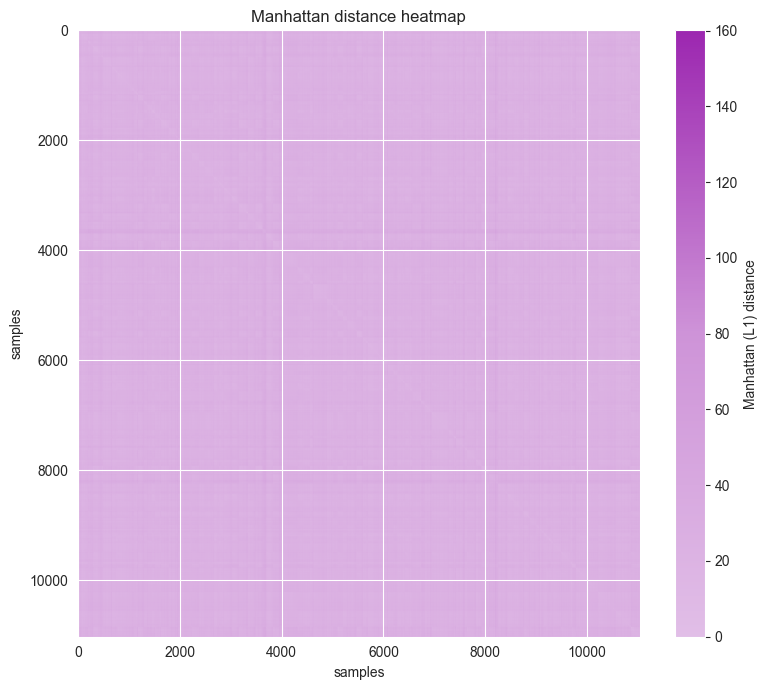

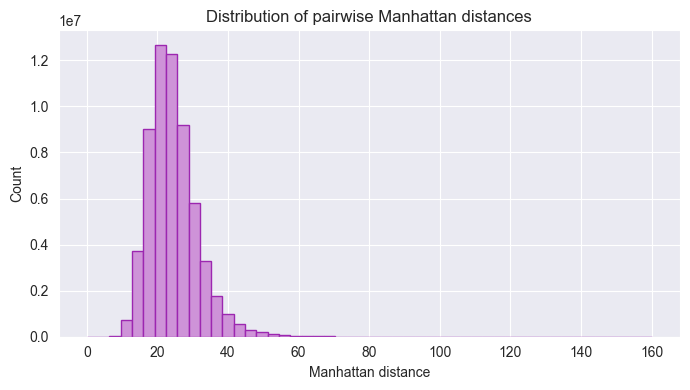

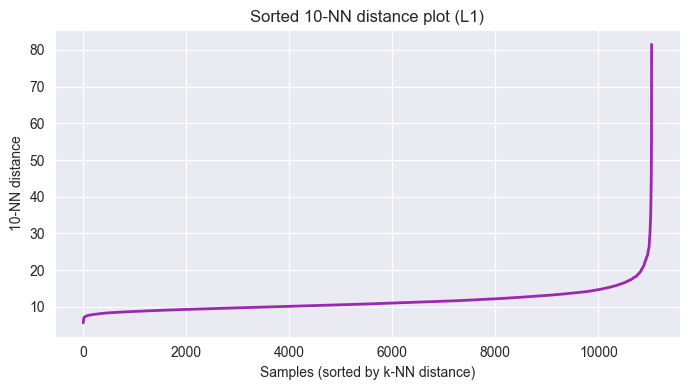

In [49]:
# ============================================
# Manhattan (L1) distance: minimal-safe pipeline + clear plots
# ============================================

# --- Custom colors (same as before) ---
hex_colors = ["#e1bee7", "#ce93d8", "#9c27b0"]
cmap_custom = LinearSegmentedColormap.from_list("custom3", hex_colors)

# --------------------------------------------
# Use full dataset (no subsampling)
# NOTE: L1, like L2, benefits from comparable feature scales.
# --------------------------------------------
X_sub = X_num  # no subsampling

# (Optional) memory warning: full distance matrix is n x n
n = X_sub.shape[0]
bytes_per = 8  # float64 by default
est_gb = (n * n * bytes_per) / (1024**3)
if est_gb > 0.5:
    print(f"[Info] Full distance matrix size ~{est_gb:.2f} GB for n={n}. "
          "Consider subsampling for very large n.")

# --------------------------------------------
# Light diagnostics: rows where Manhattan may be unsuitable
# - NaN/Inf present
# - extreme sparsity (>=95% zeros): consider cosine/Jaccard for sparse sets
# --------------------------------------------
row_has_bad = ~np.isfinite(X_sub).all(axis=1)
row_zero_ratio = (X_sub == 0).sum(axis=1) / np.maximum(1, X_sub.shape[1])
row_too_sparse = row_zero_ratio >= 0.95
bad_idx = np.where(row_has_bad | row_too_sparse)[0]
if bad_idx.size:
    print(f"[Warning] {bad_idx.size} rows may be unsuitable for Manhattan distance.")
    print(" - Reasons: NaN/Inf or extreme sparsity (>=95% zeros). "
          "Consider cosine/Jaccard or imputation/scaling.")
    print(" - Example indices:", bad_idx[:20].tolist(), ("..." if bad_idx.size > 20 else ""))

# --------------------------------------------
# Minimal NaN handling BEFORE distances
# - Drop columns that are entirely NaN
# - Median-impute remaining NaNs column-wise
# (No scaling here, to keep parity with your Euclidean cell.)
# --------------------------------------------
col_nan_counts = np.isnan(X_sub).sum(axis=0)
all_nan_cols = np.where(col_nan_counts == X_sub.shape[0])[0]
if all_nan_cols.size:
    print(f"Dropping {all_nan_cols.size} all-NaN columns:",
          all_nan_cols[:20].tolist(), ("..." if all_nan_cols.size > 20 else ""))
    X_sub = np.delete(X_sub, all_nan_cols, axis=1)

if np.isnan(X_sub).any():
    print("Median-imputing remaining NaN values column-wise.")
    X_sub = SimpleImputer(strategy="median").fit_transform(X_sub)

# --------------------------------------------
# Manhattan distance matrix (L1)
# --------------------------------------------
dist_manhattan = pairwise_distances(X_sub, metric="manhattan")

# Sanity checks: diagonal ~0, symmetry ~0
diag_max = np.abs(np.diag(dist_manhattan)).max()
sym_err = np.abs(dist_manhattan - dist_manhattan.T).max()
print(f"Diag max={diag_max:.3e} (should be ~0), symmetry max diff={sym_err:.3e} (should be ~0)")

# Small numeric preview (first 10x10)
dist_manhattan_df = pd.DataFrame(dist_manhattan)
display(dist_manhattan_df.iloc[:10, :10])

# ============================================
# Plots (with custom colors)
# ============================================

# 1) Heatmap (distances >= 0 → 0..max)
plt.figure(figsize=(8, 7))
vmax = np.nanmax(dist_manhattan)
im = plt.imshow(dist_manhattan, aspect="auto", cmap=cmap_custom, vmin=0, vmax=vmax)
plt.colorbar(im, label="Manhattan (L1) distance")
plt.title("Manhattan distance heatmap")
plt.xlabel("samples"); plt.ylabel("samples")
plt.tight_layout(); plt.show()

# 2) Histogram of pairwise distances (upper triangle, no diagonal)
triu_vals = dist_manhattan[np.triu_indices(dist_manhattan.shape[0], k=1)]
plt.figure(figsize=(7, 4))
plt.hist(triu_vals, bins=50, color=hex_colors[1], edgecolor=hex_colors[2], linewidth=1.0)
plt.xlabel("Manhattan distance"); plt.ylabel("Count")
plt.title("Distribution of pairwise Manhattan distances")
plt.tight_layout(); plt.show()

# 3) k-NN distance plot (sorted k-th neighbor) – handy for DBSCAN eps guess
k = 10  # adjust if desired
if dist_manhattan.shape[0] > k:
    D_sorted = np.sort(dist_manhattan, axis=1)   # per-row sorted distances
    kth_sorted = np.sort(D_sorted[:, k])         # 0=self, 1=1-NN, ..., k=k-NN
    plt.figure(figsize=(7, 4))
    plt.plot(kth_sorted, color=hex_colors[2], linewidth=2)
    plt.xlabel("Samples (sorted by k-NN distance)")
    plt.ylabel(f"{k}-NN distance")
    plt.title(f"Sorted {k}-NN distance plot (L1)")
    plt.tight_layout(); plt.show()
else:
    print(f"Not enough samples ({dist_manhattan.shape[0]}) for k={k} k-NN plot.")


The Manhattan-distance heatmap shows a uniformly dark and homogeneous pattern, indicating that pairwise L1 distances across samples do not form clear clusters or block structures; the dataset appears highly dispersed and lacks obvious grouping in feature space. The histogram confirms this by showing a unimodal distribution centered around moderate distances, with most pairwise distances concentrated between roughly 15 and 35, and only a small tail of larger values. The sorted 10-nearest-neighbor distance curve increases gradually for most samples and rises sharply only at the very end, meaning that the vast majority of points have reasonably close neighbors, while a small fraction of samples are more isolated. Overall, the three plots suggest a dataset with no strong clustering, a fairly consistent density, and only a limited number of potential outliers or sparsely located points.

#### Cosine similarity

Measures how similar the "shape" of feature vectors is, ignoring magnitude. Good for "profiles" (audio features, etc.).

[Warning] Using cosine on X_num (dense). Cosine is typically best for TF-IDF/sparse or embeddings; ensure direction matters more than magnitude.
[Cosine] Using matrix from: X_num (fallback) | shape=(11032, 28)
[Info] Replacing NaN/Inf with 0 for cosine (better to impute upstream if needed).
[Cosine] Diag max=0.000e+00 (≈0 expected), symmetry max diff=0.000e+00 (≈0 expected)


,0,1,2,3,4,5,6,7,8,9
0,0.000000,0.085260,0.492893,0.851014,1.147609,1.296321,0.707743,0.627639,0.721997,0.944594
1,0.085260,0.000000,0.444752,0.951103,0.974147,1.280814,0.694422,0.462896,0.603453,0.782003
2,0.492893,0.444752,0.000000,0.653000,1.066151,1.192052,0.361462,0.145483,0.633695,0.587534
3,0.851014,0.951103,0.653000,0.000000,1.389357,1.055377,0.964281,0.926884,1.241515,0.985513
4,1.147609,0.974147,1.066151,1.389357,0.000000,0.414488,0.655020,0.808060,0.590530,0.476088
5,1.296321,1.280814,1.192052,1.055377,0.414488,0.000000,0.816016,1.110522,1.049023,0.688702
6,0.707743,0.694422,0.361462,0.964281,0.655020,0.816016,0.000000,0.385089,0.296383,0.348549
7,0.627639,0.462896,0.145483,0.926884,0.808060,1.110522,0.385089,0.000000,0.540648,0.468158
8,0.721997,0.603453,0.633695,1.241515,0.590530,1.049023,0.296383,0.540648,0.000000,0.522093
9,0.944594,0.782003,0.587534,0.985513,0.476088,0.688702,0.348549,0.468158,0.522093,0.000000


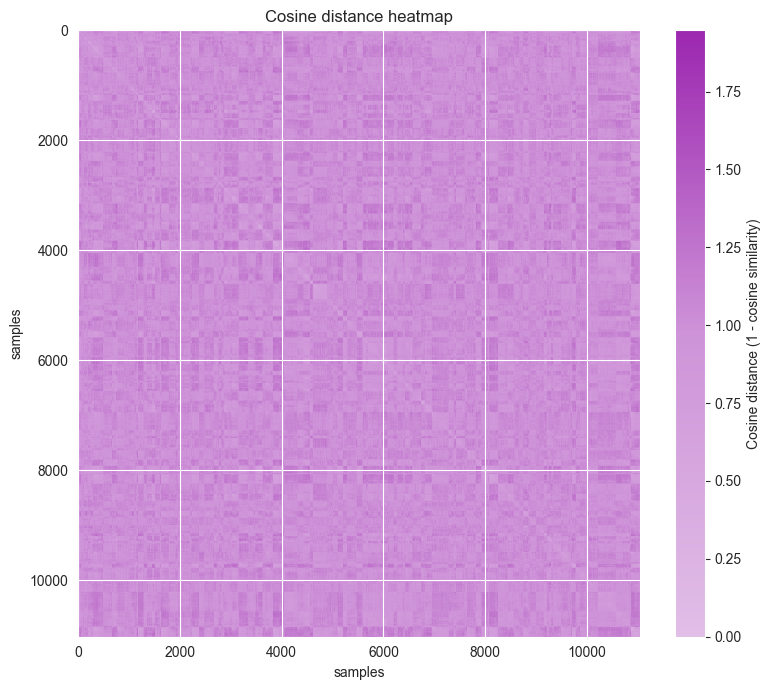

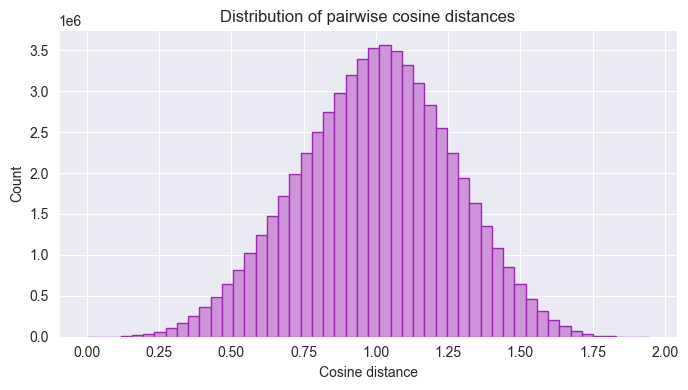

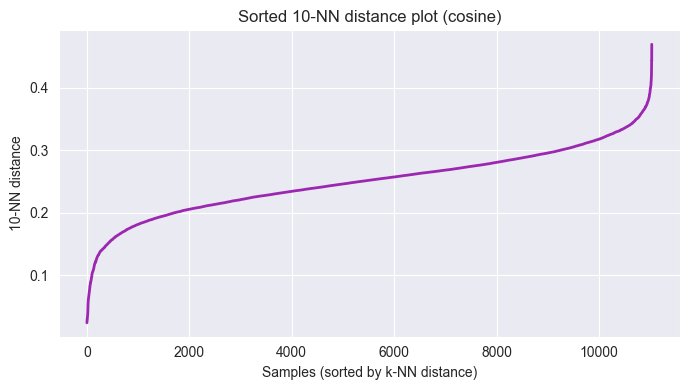

In [50]:
# ===== Custom colors =====
hex_colors = ["#e1bee7", "#ce93d8", "#9c27b0"]
cmap_custom = LinearSegmentedColormap.from_list("custom3", hex_colors)

# ------- 0) Pick the data matrix for cosine (sparse/text-like preferred) -------
X_cos = None
source = None

# Highest priority: user already has TF-IDF or a sparse text matrix
if "X_tfidf" in globals():
    X_cos = globals()["X_tfidf"]
    source = "X_tfidf"
elif "X_sparse" in globals():
    X_cos = globals()["X_sparse"]
    source = "X_sparse"
# Next: try to auto-select sparse/count-like columns from df (non-negative, high sparsity)
elif "df" in globals():
    # Heuristic: numeric non-negative columns with high zero ratio (>=80%) are text/count-like
    cand = []
    for c in df.select_dtypes(include=[np.number]).columns:
        s = df[c]
        if (s.dropna() >= 0).all():  # non-negative
            zero_ratio = (s == 0).mean()
            if zero_ratio >= 0.80:
                cand.append(c)
    if len(cand) >= 2:
        mat = df[cand].fillna(0.0).to_numpy(dtype=np.float32)
        if sparse is not None:
            X_cos = sparse.csr_matrix(mat)
            source = f"auto-selected {len(cand)} sparse/count-like cols from df"
        else:
            X_cos = mat
            source = f"auto-selected {len(cand)} dense count-like cols from df"
            print("[Info] SciPy not available: using dense matrix for cosine (works, but less memory-efficient).")
# Fallback: use X_num but warn (cosine may not be the best if dense & scaled)
if X_cos is None and "X_num" in globals():
    X_cos = np.asarray(X_num)
    source = "X_num (fallback)"
    print("[Warning] Using cosine on X_num (dense). Cosine is typically best for TF-IDF/sparse or embeddings; "
          "ensure direction matters more than magnitude.")

if X_cos is None:
    raise NameError("No suitable matrix found for cosine. Provide X_tfidf/X_sparse, or ensure df/X_num exist.")

print(f"[Cosine] Using matrix from: {source} | shape={X_cos.shape}")

# ------- 1) Minimal cleaning & row-norm guard -------
# Cosine requires non-zero rows; remove all-zero rows and report them.
if (sparse is not None) and hasattr(sparse, "issparse") and sparse.issparse(X_cos):
    row_norms = np.sqrt(X_cos.multiply(X_cos).sum(axis=1)).A.ravel()
    zero_rows = np.where(row_norms == 0)[0]
    if zero_rows.size:
        print(f"[Info] Removing {zero_rows.size} all-zero rows (cosine undefined).")
        mask = np.ones(X_cos.shape[0], dtype=bool); mask[zero_rows] = False
        X_cos = X_cos[mask]
else:
    # Dense: check NaN/Inf and zero rows
    if not np.isfinite(X_cos).all():
        print("[Info] Replacing NaN/Inf with 0 for cosine (better to impute upstream if needed).")
        X_cos = np.nan_to_num(X_cos, copy=False)
    row_norms = np.linalg.norm(X_cos, axis=1)
    zero_rows = np.where(row_norms == 0)[0]
    if zero_rows.size:
        print(f"[Info] Removing {zero_rows.size} all-zero rows (cosine undefined).")
        X_cos = np.delete(X_cos, zero_rows, axis=0)

# Optional: ensure unit-norm rows (pairwise_distances with 'cosine' can handle it, but normalization helps numerics)
Xn = normalize(X_cos, norm="l2", axis=1, copy=False)

# ------- 2) Cosine distance matrix -------
# Note: cosine distance = 1 - cosine similarity
D_cosine = pairwise_distances(Xn, metric="cosine")  # tipicamente in [0, 1] con TF-IDF

# Sanity checks
diag_max = np.abs(np.diag(D_cosine)).max()
sym_err = np.abs(D_cosine - D_cosine.T).max()
print(f"[Cosine] Diag max={diag_max:.3e} (≈0 expected), symmetry max diff={sym_err:.3e} (≈0 expected)")

# Small numeric preview (first 10x10)
D_cosine_df = pd.DataFrame(D_cosine)
display(D_cosine_df.iloc[:10, :10])

# ------- 3) Plots (heatmap + histogram + k-NN) -------
# 1) Heatmap
plt.figure(figsize=(8, 7))
vmax = np.nanmax(D_cosine)
im = plt.imshow(D_cosine, aspect="auto", cmap=cmap_custom, vmin=0, vmax=vmax)
plt.colorbar(im, label="Cosine distance (1 - cosine similarity)")
plt.title("Cosine distance heatmap")
plt.xlabel("samples"); plt.ylabel("samples")
plt.tight_layout(); plt.show()

# 2) Histogram of pairwise cosine distances (upper triangle, no diagonal)
triu_vals = D_cosine[np.triu_indices(D_cosine.shape[0], k=1)]
plt.figure(figsize=(7, 4))
plt.hist(triu_vals, bins=50, color=hex_colors[1], edgecolor=hex_colors[2], linewidth=1.0)
plt.xlabel("Cosine distance"); plt.ylabel("Count")
plt.title("Distribution of pairwise cosine distances")
plt.tight_layout(); plt.show()

# 3) k-NN distance plot (sorted k-th neighbor) – handy for DBSCAN eps
k = 10
if D_cosine.shape[0] > k:
    D_sorted = np.sort(D_cosine, axis=1)
    kth_sorted = np.sort(D_sorted[:, k])  # 0=self, 1=1-NN, ..., k=k-NN
    plt.figure(figsize=(7, 4))
    plt.plot(kth_sorted, color=hex_colors[2], linewidth=2)
    plt.xlabel("Samples (sorted by k-NN distance)")
    plt.ylabel(f"{k}-NN distance")
    plt.title(f"Sorted {k}-NN distance plot (cosine)")
    plt.tight_layout(); plt.show()
else:
    print(f"Not enough samples ({D_cosine.shape[0]}) for k={k} k-NN plot.")


The cosine-distance heatmap shows a highly uniform and noise-like pattern, with no visible blocks or structured regions, indicating that samples do not form clear directional clusters in the feature space. This suggests that the angles between feature vectors vary smoothly across the dataset, with no strong grouping by orientation. The histogram reinforces this impression: cosine distances follow a roughly symmetric, bell-shaped distribution centered around 1.0, meaning that most pairs of samples are neither strongly similar nor strongly dissimilar in direction, but lie in a broad intermediate range. The sorted 10-nearest-neighbor distance curve rises gradually and remains low for most samples, showing that each point has reasonably close neighbors in terms of vector orientation, while only a small number of samples appear more isolated. Overall, cosine geometry paints a picture of a dataset that is dense, smoothly distributed, and lacking clear directional clusters.

#### Jaccard distance (binary features only)

Use this only on {0,1} columns (e.g., explicit flags, binary tags).

[Jaccard] Using matrix from: auto-selected 27 non-negative cols from df | shape=(11032, 27) | mode=weighted
[Jaccard] Diag max=0.000e+00 (≈0), symmetry max diff=0.000e+00 (≈0)


,0,1,2,3,4,5,6,7,8,9
0,0.000000,0.079830,0.373191,0.481497,0.429169,0.418436,0.499496,0.510527,0.505137,0.483448
1,0.079830,0.000000,0.323074,0.439746,0.381186,0.369803,0.458615,0.470620,0.463642,0.440047
2,0.373191,0.323074,0.000000,0.173537,0.099566,0.122799,0.202445,0.222031,0.214438,0.176941
3,0.481497,0.439746,0.173537,0.000000,0.134720,0.155069,0.067805,0.073719,0.142460,0.180436
4,0.429169,0.381186,0.099566,0.134720,0.000000,0.031323,0.130346,0.153927,0.143118,0.097772
5,0.418436,0.369803,0.122799,0.155069,0.031323,0.000000,0.147479,0.170683,0.160755,0.116929
6,0.499496,0.458615,0.202445,0.067805,0.130346,0.147479,0.000000,0.027652,0.081835,0.126103
7,0.510527,0.470620,0.222031,0.073719,0.153927,0.170683,0.027652,0.000000,0.082026,0.131278
8,0.505137,0.463642,0.214438,0.142460,0.143118,0.160755,0.081835,0.082026,0.000000,0.056699
9,0.483448,0.440047,0.176941,0.180436,0.097772,0.116929,0.126103,0.131278,0.056699,0.000000


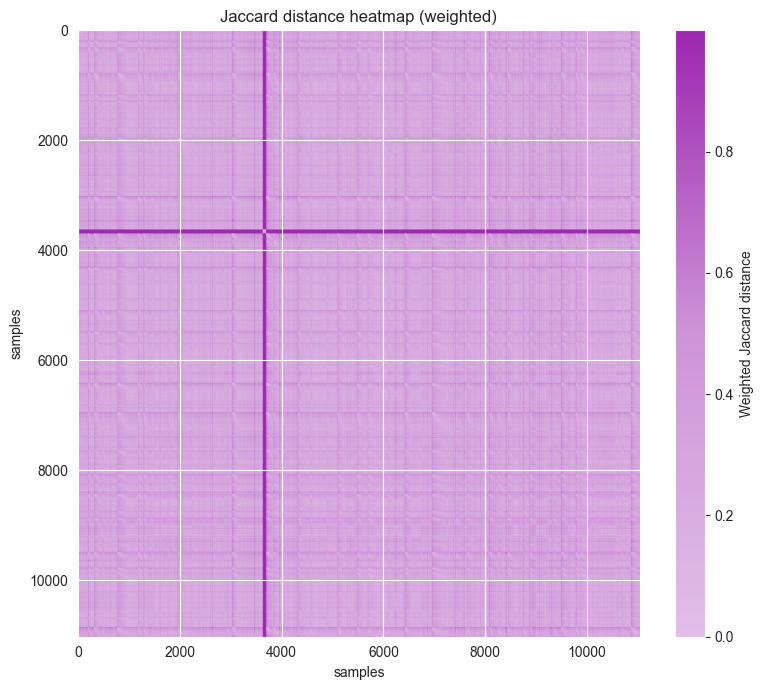

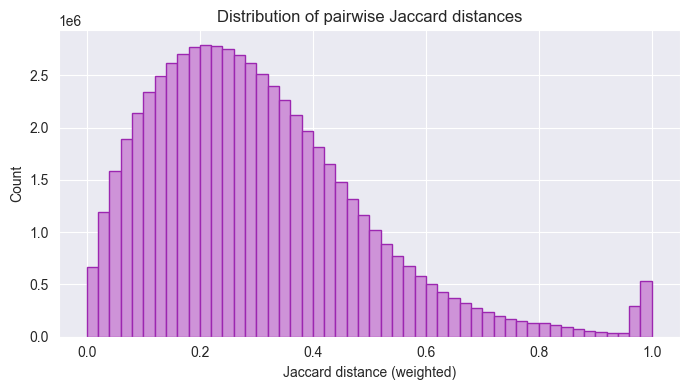

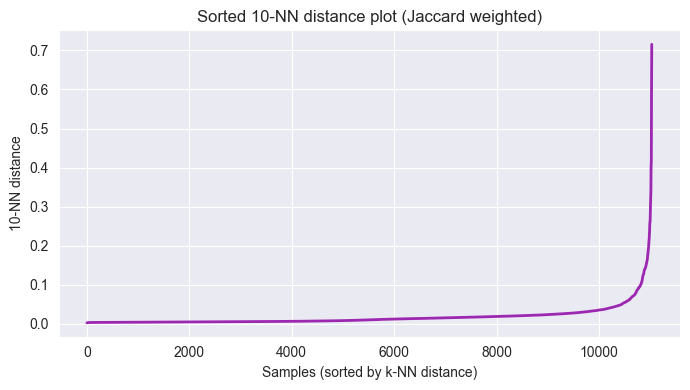

In [51]:
# ============================================
# Jaccard distance: use only where it is ideal/better
# - Binary Jaccard for sets / 0-1 indicators (ideal)
# - Weighted Jaccard (Tanimoto) for non-negative counts/weights
# ============================================

# ---- Custom colors ----
hex_colors = ["#e1bee7", "#ce93d8", "#9c27b0"]
cmap_custom = LinearSegmentedColormap.from_list("custom3", hex_colors)

# ---------- 0) Pick a suitable matrix for Jaccard ----------
X_jac = None
source = None
mode = None  # "binary" or "weighted"

# Priority 1: explicit binary matrices
for name in ("X_bool", "X_binary"):
    if name in globals():
        X_jac = globals()[name]
        source = name
        mode = "binary"
        break

# Priority 2: explicit counts matrix for weighted jaccard
if X_jac is None and "X_counts" in globals():
    X_jac = np.asarray(globals()["X_counts"])
    source = "X_counts"
    mode = "weighted"

# Priority 3: auto-select sparse/count-like columns from df
if X_jac is None and "df" in globals():
    num_cols = df.select_dtypes(include=[np.number]).columns
    # Heuristic: non-negative & very sparse → treat as set presence (binary Jaccard)
    cand_sparse = []
    for c in num_cols:
        s = df[c]
        if (s.dropna() >= 0).all():
            zero_ratio = (s == 0).mean()
            if zero_ratio >= 0.80:
                cand_sparse.append(c)
    if len(cand_sparse) >= 2:
        mat = df[cand_sparse].fillna(0.0).to_numpy()
        # If values are exactly 0/1 (or can be binarized), use binary mode
        # We'll binarize by presence: >0 -> 1
        X_jac = (mat > 0).astype(np.uint8)
        source = f"auto-selected {len(cand_sparse)} sparse cols from df"
        mode = "binary"
    else:
        # If we have many non-negative columns but not sparse enough, use weighted
        cand_nonneg = [c for c in num_cols if (df[c].dropna() >= 0).all()]
        if len(cand_nonneg) >= 2:
            X_jac = df[cand_nonneg].fillna(0.0).to_numpy()
            source = f"auto-selected {len(cand_nonneg)} non-negative cols from df"
            mode = "weighted"

# Final safety: do not fallback to arbitrary dense numeric (Jaccard not ideal)
if X_jac is None:
    raise NameError(
        "No suitable matrix for Jaccard. Provide a binary indicator matrix (X_bool/X_binary) "
        "or non-negative counts (X_counts), or ensure df has non-negative sparse/count-like columns."
    )

print(f"[Jaccard] Using matrix from: {source} | shape={getattr(X_jac, 'shape', None)} | mode={mode}")

# ---------- 1) Clean/validate rows ----------
# Remove all-zero rows (Jaccard undefined)
def _row_l2_norm(a):
    return np.sqrt((a * a).sum(axis=1)) if a.ndim == 2 else np.linalg.norm(a, axis=1)

if sparse is not None and hasattr(sparse, "issparse") and sparse.issparse(X_jac):
    row_sums = X_jac.sum(axis=1).A.ravel() if mode == "binary" else X_jac.multiply(1).sum(axis=1).A.ravel()
    zero_rows = np.where(row_sums == 0)[0]
    if zero_rows.size:
        print(f"[Info] Removing {zero_rows.size} all-zero rows (Jaccard undefined).")
        mask = np.ones(X_jac.shape[0], dtype=bool); mask[zero_rows] = False
        X_jac = X_jac[mask]
else:
    X_jac = np.asarray(X_jac)
    if mode == "binary":
        # Ensure binary {0,1}
        X_jac = (X_jac > 0).astype(np.uint8)
        row_sums = X_jac.sum(axis=1)
    else:
        # Weighted: ensure non-negative
        if (X_jac < 0).any():
            raise ValueError("Weighted Jaccard requires non-negative values.")
        row_sums = X_jac.sum(axis=1)
    zero_rows = np.where(row_sums == 0)[0]
    if zero_rows.size:
        print(f"[Info] Removing {zero_rows.size} all-zero rows (Jaccard undefined).")
        X_jac = np.delete(X_jac, zero_rows, axis=0)

# ---------- 2) Distance computation ----------
def weighted_jaccard_distance(X):
    """
    Compute weighted Jaccard/Tanimoto distance for non-negative X (n x d).
    distance_ij = 1 - sum_k min(xik, xjk) / sum_k max(xik, xjk)
    """
    # Efficient but memory-heavy O(n^2 d); for large n consider chunking.
    X = np.asarray(X)
    n, d = X.shape
    # Broadcast min/max across pairs
    X_i = X[:, None, :]           # (n,1,d)
    X_j = X[None, :, :]           # (1,n,d)
    num = np.minimum(X_i, X_j).sum(axis=2)  # (n,n)
    den = np.maximum(X_i, X_j).sum(axis=2)  # (n,n)
    sim = np.divide(num, den, out=np.zeros_like(num, dtype=float), where=den!=0)
    return 1.0 - sim

if mode == "binary":
    # scikit-learn jaccard expects boolean/binary
    if sparse is not None and hasattr(sparse, "issparse") and sparse.issparse(X_jac):
        Xb = X_jac.astype(bool)
    else:
        Xb = X_jac.astype(bool)
    D_jaccard = pairwise_distances(Xb, metric="jaccard")
else:
    # Weighted Jaccard
    D_jaccard = weighted_jaccard_distance(X_jac)

# Sanity checks
diag_max = np.abs(np.diag(D_jaccard)).max()
sym_err = np.abs(D_jaccard - D_jaccard.T).max()
print(f"[Jaccard] Diag max={diag_max:.3e} (≈0), symmetry max diff={sym_err:.3e} (≈0)")

# Preview 10x10
D_jaccard_df = pd.DataFrame(D_jaccard)
display(D_jaccard_df.iloc[:10, :10])

# ---------- 3) Plots (heatmap + histogram + k-NN) ----------
# 1) Heatmap
plt.figure(figsize=(8, 7))
vmax = np.nanmax(D_jaccard)
im = plt.imshow(D_jaccard, aspect="auto", cmap=cmap_custom, vmin=0, vmax=vmax)
plt.colorbar(im, label=("Jaccard distance (binary)" if mode=="binary" else "Weighted Jaccard distance"))
plt.title("Jaccard distance heatmap" + ("" if mode=="binary" else " (weighted)"))
plt.xlabel("samples"); plt.ylabel("samples")
plt.tight_layout(); plt.show()

# 2) Histogram of pairwise distances (upper triangle, no diagonal)
triu_vals = D_jaccard[np.triu_indices(D_jaccard.shape[0], k=1)]
plt.figure(figsize=(7, 4))
plt.hist(triu_vals, bins=50, color=hex_colors[1], edgecolor=hex_colors[2], linewidth=1.0)
plt.xlabel("Jaccard distance" + ("" if mode=="binary" else " (weighted)"))
plt.ylabel("Count")
plt.title("Distribution of pairwise Jaccard distances")
plt.tight_layout(); plt.show()

# 3) k-NN distance plot (sorted k-th neighbor)
k = 10
if D_jaccard.shape[0] > k:
    D_sorted = np.sort(D_jaccard, axis=1)
    kth_sorted = np.sort(D_sorted[:, k])  # 0=self, 1=1-NN, ..., k=k-NN
    plt.figure(figsize=(7, 4))
    plt.plot(kth_sorted, color=hex_colors[2], linewidth=2)
    plt.xlabel("Samples (sorted by k-NN distance)")
    plt.ylabel(f"{k}-NN distance")
    plt.title(f"Sorted {k}-NN distance plot (Jaccard{' weighted' if mode=='weighted' else ''})")
    plt.tight_layout(); plt.show()
else:
    print(f"Not enough samples ({D_jaccard.shape[0]}) for k={k} k-NN plot.")

The weighted-Jaccard heatmap shows a mostly uniform pattern with faint grid-like structures, suggesting that samples share similar sets of non-zero features and do not form well-defined clusters. A few bright horizontal and vertical lines indicate isolated samples whose feature composition differs noticeably from the rest, but these cases are rare. The 10-nearest-neighbor distance curve remains close to zero for the majority of points and increases sharply only at the far right, meaning that most samples have extremely similar neighbors in terms of weighted feature overlap, while a small subset appears more distinct. The histogram confirms this interpretation: Jaccard distances are concentrated between 0.1 and 0.4, showing substantial feature overlap across pairs, with a long tail toward higher distances and a small peak at 1.0 corresponding to pairs with disjoint or nearly disjoint feature sets. Overall, the dataset appears highly redundant under the weighted-Jaccard metric, with only a few structurally unusual or sparse samples standing out.